### Import All Libraries Required

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
from datetime import date, datetime
from scipy.stats import f_oneway,ttest_ind,spearmanr
import os
from sklearn.feature_selection import mutual_info_regression, f_classif, f_regression
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder,OneHotEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import catboost
import lightgbm as lgb

In [10]:
path="C:/Users/priyamboda.ghosh/Desktop/Priyamboda-Personal/Personal/Data Science/ML Projects for Portfolio/Regression of Used Car Prices/"

### Read the Data

In [11]:
train_df=pd.read_csv(path+"train.csv",encoding='latin')
print("Train dataset shape:",train_df.shape)

Train dataset shape: (188533, 13)


##### Check for any duplicate record

In [12]:
print("Train dataset duplicates:",train_df.duplicated().sum())

Train dataset duplicates: 0


##### Set the column 'id' as index

In [13]:
train_df.set_index(['id'],inplace=True,drop=True)

In [14]:
train_df.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


### Exploratory Data Analysis

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [16]:
train_df.nunique()

brand             57
model           1897
model_year        34
milage          6651
fuel_type          7
engine          1117
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [17]:
train_df.isin(['â']).sum()/len(train_df)*100

brand           0.000000
model           0.000000
model_year      0.000000
milage          0.000000
fuel_type       0.414251
engine          0.490630
transmission    0.046146
ext_col         0.194130
int_col         2.401171
accident        0.000000
clean_title     0.000000
price           0.000000
dtype: float64

##### Most of the columns are text with large number of distinct values. Missing values and junk characters exist in 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col' columns.
##### Replacing such junk characters with null values.

In [18]:
train_df.replace({'â':np.nan},inplace=True)

In [19]:
train_df.isnull().sum()/len(train_df)*100

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        3.110331
engine           0.490630
transmission     0.046146
ext_col          0.194130
int_col          2.401171
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [20]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [21]:
train_df.describe(include='all')

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,188533,188533,188533.00,188533.00,182669,187608,188446,188167,184006,186081,167114,188533.00
unique,57,1897,NaN,NaN,6,1116,51,318,155,2,1,NaN
top,Ford,F-150 XLT,NaN,NaN,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,NaN
freq,23088,2945,NaN,NaN,165940,3462,49904,48658,107674,144514,167114,NaN
mean,NaN,NaN,2015.83,65705.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43878.02
std,NaN,NaN,5.66,49798.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78819.52
min,NaN,NaN,1974.00,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.00
25%,NaN,NaN,2013.00,24115.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17000.00
50%,NaN,NaN,2017.00,57785.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30825.00
75%,NaN,NaN,2020.00,95400.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49900.00


### Derive new columns from existing columns

##### The price of a used car is dependent more on the brand and model of the car together, rather than separately each. hence, I am combining these two columns into one single column.

In [22]:
train_df['brand_model']=train_df['brand'].astype(str) + '-' + train_df['model'].astype(str)

##### Add new column 'car_age' derived from 'model_year'

In [23]:
print("Max model year in train:",train_df.model_year.max())

Max model year in train: 2024


In [24]:
train_df['car_age']=2025-train_df['model_year']

##### Fill up missing values in column 'fuel_type' derived from column 'engine'

In [25]:
train_df.fuel_type.value_counts().sort_values(ascending=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [26]:
def fuel_type_from_engine(df):
    df = df.copy()  # Avoid changing original DataFrame
    def engine_fuel (str_val):        
        match_string=r"\s?([A-Z]*[a-z]*)\s?Fuel"
        match=re.search(match_string,str(str_val))
        return match.group(1) if match else np.nan

    def engine_electric(str_val):
        match_string=r"Electric|Battery|\d+V|\d+kW"
        match=re.search(match_string,str(str_val))
        return 'Electric' if match else np.nan

    mask=((df['fuel_type'].isnull()) | (df['fuel_type']=='not supported'))
    df.loc[mask,'fuel_type']=df.loc[mask,'engine'].map(engine_fuel)
    df.loc[mask,'fuel_type']=df.loc[mask,'engine'].map(engine_electric)
    df.loc[df['fuel_type']=='Flex','fuel_type']='E85 Flex Fuel'
    df.loc[df['fuel_type']=='Plug-In Hybrid','fuel_type']='Hybrid'
    #print(df.fuel_type.value_counts().sort_values(ascending=False))

    return df

fuel_type_fixer=FunctionTransformer(func=fuel_type_from_engine,validate=False)

In [27]:
#fuel_type_from_engine=joblib.load(path+"func_fuel_type_from_engine.pkl")
train_df=fuel_type_from_engine(train_df)
train_df.shape

(188533, 14)

In [28]:
# Filling in missing values of 'fuel_type' from median of 'brand','model':

train_df.loc[train_df['fuel_type'].isnull(),'fuel_type']=train_df[train_df['fuel_type'].notnull()].groupby(['brand_model'])['fuel_type'].transform(lambda x:x.replace(np.nan,x.mode()[0]))
train_df.loc[train_df['fuel_type'].isnull(),'fuel_type']=train_df['fuel_type'].transform(lambda x:x.replace(np.nan,x.mode()[0]))

In [29]:
train_df.fuel_type.value_counts()

fuel_type
Gasoline         166886
Hybrid             7353
E85 Flex Fuel      5406
Electric           4933
Diesel             3955
Name: count, dtype: int64

In [30]:
train_df.fuel_type.isnull().sum()

0

In [31]:
fuel_type_map1=train_df.groupby(['brand_model'])['fuel_type'].agg(lambda x: x.mode()[0]).to_dict()
fuel_type_map2=train_df['fuel_type'].agg(lambda x: x.mode()[0])

##### Add new columns 'engine_hp', 'engine_liter' and 'engine_cylinder' derived from column 'engine'

In [32]:
#train_df.engine.value_counts().sort_values(ascending=False)

In [33]:
def engine_hp_from_engine(df):
    df = df.copy()  # Avoid changing original DataFrame
    def engine_hp (str_val):
        match_string=r"(\d+\.?\d*)HP"
        match=re.search(match_string,str(str_val))    
        return float(match.group(1)) if match else np.nan

    df['engine_hp']=df['engine'].map(engine_hp)
    return df

engine_hp_fixer=FunctionTransformer(func=engine_hp_from_engine,validate=False)

In [34]:
train_df=engine_hp_from_engine(train_df)
train_df.shape

(188533, 15)

In [35]:
train_df.engine_hp.isnull().sum()/len(train_df)*100

17.640943495303212

In [36]:
#test_df.engine_hp.isnull().sum()/len(test_df)*100

##### The newly derived column 'engine_hp' has 18% missing values. Filling up such missing values with the following logic:
###### 1. Median value of respective brand-model-fuel_type group
###### 2. Median value of respective brand-model group
###### 3. Median value of respective brand group
###### 4. Median value of the column

In [37]:
train_df.loc[train_df['engine_hp'].isnull(),'engine_hp']=train_df[train_df['engine_hp'].notnull()].groupby(['brand_model','fuel_type'])['engine_hp'].transform(lambda x:x.replace(np.nan,x.median()))
train_df.loc[train_df['engine_hp'].isnull(),'engine_hp']=train_df[train_df['engine_hp'].notnull()].groupby(['brand_model'])['engine_hp'].transform(lambda x:x.replace(np.nan,x.median()))
train_df.loc[train_df['engine_hp'].isnull(),'engine_hp']=train_df['engine_hp'].transform(lambda x:x.replace(np.nan,x.median()))

In [38]:
train_df.engine_hp.isnull().sum()/len(train_df)*100

0.0

In [39]:
# Dictionary for mapping 'engine_hp' values:
engine_hp_map1=train_df.groupby(['brand_model','fuel_type'])['engine_hp'].median().to_dict()
engine_hp_map2=train_df.groupby(['brand_model'])['engine_hp'].median().to_dict()
engine_hp_map3=train_df['engine_hp'].median()

In [40]:
#test_df.engine_hp.isnull().sum()/len(test_df)*100

In [41]:
def engine_liter_from_engine(df):
    df = df.copy()  # Avoid changing original DataFrame
    def engine_liter (str_val):
        match_string=r"(\d+\.?\d*)[L|l]"
        match=re.search(match_string,str(str_val))
    
        return float(match.group(1)) if match else np.nan

    df['engine_liter']=df['engine'].map(engine_liter)
    return df

engine_liter_fixer=FunctionTransformer(func=engine_liter_from_engine,validate=False)

In [42]:
train_df=engine_liter_from_engine(train_df)

In [43]:
train_df.engine_liter.isnull().sum()/len(train_df)*100

7.539263683280911

##### The newly derived column 'engine_liter' has 8% missing values. Filling up such missing values with the following logic:
###### 1. Median value of respective brand-model-fuel_type group
###### 2. Median value of respective brand-model group
###### 3. Median value of respective brand group
###### 4. Median value of the column

In [44]:
train_df.loc[(train_df['engine_liter'].isnull()) & (train_df['fuel_type']=='Electric'),'engine_liter']=0 # engine_liter is irrelevant for electric cars
train_df.loc[train_df['engine_liter'].isnull(),'engine_liter']=train_df[train_df['engine_liter'].notnull()].groupby(['brand_model','fuel_type'])['engine_liter'].transform(lambda x:x.replace(np.nan,x.median()))
train_df.loc[train_df['engine_liter'].isnull(),'engine_liter']=train_df[train_df['engine_liter'].notnull()].groupby(['brand_model'])['engine_liter'].transform(lambda x:x.replace(np.nan,x.median()))
train_df.loc[train_df['engine_liter'].isnull(),'engine_liter']=train_df['engine_liter'].transform(lambda x:x.replace(np.nan,x.median()))

In [45]:
train_df.engine_liter.isnull().sum()/len(train_df)*100

0.0

In [46]:
engine_liter_map1=train_df.groupby(['brand_model','fuel_type'])['engine_liter'].median().to_dict()
engine_liter_map2=train_df.groupby(['brand_model'])['engine_liter'].median().to_dict()
engine_liter_map3=train_df['engine_liter'].median()

In [47]:
def engine_cylinder_from_engine(df):
    df = df.copy()  # Avoid changing original DataFrame
    def engine_cylinder (str_val):
        match_string1=r"(\d+)\s*Cylinder"
        match1=re.search(match_string1,str(str_val))
    
        match_string2=r"I(\d+)\s*"
        match2=re.search(match_string2,str(str_val))
    
        match_string3=r"V(\d+)\s*"
        match3=re.search(match_string3,str(str_val))
    
        if match1:
            return float(match1.group(1))
        elif match2:
            return float(match2.group(1))
        elif match3:
            return float(match3.group(1))
        else:
            return np.nan
   
    df['engine_cylinder']=df['engine'].map(engine_cylinder)

    return df

engine_cylinder_fixer=FunctionTransformer(func=engine_cylinder_from_engine,validate=False)

In [48]:
train_df=engine_cylinder_from_engine(train_df)

In [49]:
train_df.engine_cylinder.isnull().sum()/len(train_df)*100

8.054823293534819

##### The newly derived column 'engine_cylinder' has 8% missing values. Filling up such missing values with the following logic:
###### 1. Median value of respective brand-model-fuel_type group
###### 2. Median value of respective brand-model group
###### 3. Median value of respective brand group
###### 4. Median value of the column

In [50]:
train_df.loc[(train_df['engine_cylinder'].isnull()) & (train_df['fuel_type']=='Electric'),'engine_cylinder']=0 # engine_cylinder is irrelevant for electric cars
train_df.loc[train_df['engine_cylinder'].isnull(),'engine_cylinder']=train_df[train_df['engine_cylinder'].notnull()].groupby(['brand_model','fuel_type'])['engine_cylinder'].transform(lambda x:x.replace(np.nan,x.median()))
train_df.loc[train_df['engine_cylinder'].isnull(),'engine_cylinder']=train_df[train_df['engine_cylinder'].notnull()].groupby(['brand_model'])['engine_cylinder'].transform(lambda x:x.replace(np.nan,x.median()))
train_df.loc[train_df['engine_cylinder'].isnull(),'engine_cylinder']=train_df['engine_cylinder'].transform(lambda x:x.replace(np.nan,x.median()))

In [51]:
train_df.engine_cylinder.isnull().sum()/len(train_df)*100

0.0

In [52]:
engine_cylinder_map1=train_df.groupby(['brand_model','fuel_type'])['engine_cylinder'].median().to_dict()
engine_cylinder_map2=train_df.groupby(['brand_model'])['engine_cylinder'].median().to_dict()
engine_cylinder_map3=train_df['engine_cylinder'].median()

##### The column 'transmission' has high cardinality. I am picking up the key transmission type 'Manual' or 'Automatic' or 'CVT' from these various different string values and placing them in new column 'transmission_type'.

In [53]:
#train_df.transmission.value_counts().sort_values(ascending=False)

In [54]:
def transmission_type_from_transmission(df):
    df = df.copy()  # Avoid changing original DataFrame
    def transmission_type(str_val):
        match_string1=r"A/T|a/t|A/t|a/T|Automatic|automatic|AT|at|At|aT"
        match1=re.search(match_string1,str(str_val))
    
        match_string2=r"M/T|m/t|M/t|m/T|Manual|manual|MT|mt|Mt|mT"
        match2=re.search(match_string2,str(str_val))
    
        match_string3=r"CVT"
        match3=re.search(match_string3,str(str_val))
    
        if match1:
            return 'automatic'
        elif match2:
            return 'manual'
        elif match3:
            return 'CVT'
        else:
            return np.nan
    
    df['transmission_type']=df['transmission'].map(transmission_type)
    df.loc[(df['transmission_type'].isnull()) & (df['transmission']=='Transmission w/Dual Shift Mode'),'transmission_type']='automatic'
    df.loc[(df['transmission_type'].isnull()),'transmission_type']='manual'
    return df

transmission_type_fixer=FunctionTransformer(func=transmission_type_from_transmission,validate=False)

In [55]:
#train_df[train_df['transmission_type'].isnull()]['transmission'].value_counts().sort_values(ascending=False)

In [56]:
#test_df[test_df['transmission_type'].isnull()]['transmission'].value_counts().sort_values(ascending=False)

In [57]:
train_df=transmission_type_from_transmission(train_df)

In [58]:
train_df.transmission_type.isnull().sum()

0

In [59]:
transmission_type_map1=train_df.groupby(['brand_model'])['transmission_type'].apply(lambda x:x.mode()[0]).to_dict()
transmission_type_map2=train_df['transmission_type'].mode()[0]

In [60]:
#train_df.transmission_type.value_counts().sort_values(ascending=False)

In [61]:
#test_df.transmission_type.value_counts().sort_values(ascending=False)

In [62]:
# Finding the 'speed_count' from column 'transmission'
def speed_count(str_val):
    match_string=r"(\d+)\s*-*\s*Speed"
    match=re.search(match_string,str(str_val))
    
    return int(match.group(1)) if match else np.nan

train_df['speed_count']=train_df['transmission'].map(speed_count)

In [63]:
train_df.speed_count.isnull().sum()/len(train_df)*100

44.765107434772695

##### The missing values in the derived column speed_count is very high (around 44%). Hence it is NOT appropriate to treat such missing values with approximation. I am dropping this column.

In [64]:
train_df.drop(columns=['speed_count'],inplace=True)

In [65]:
train_df.loc[train_df['ext_col'].isnull(),'ext_col']=train_df[train_df['ext_col'].notnull()].groupby(['brand_model'])['ext_col'].transform(lambda x:x.replace(np.nan,x.mode()[0]))
train_df.loc[train_df['ext_col'].isnull(),'ext_col']=train_df['ext_col'].transform(lambda x:x.replace(np.nan,x.mode()[0]))

In [66]:
train_df.loc[train_df['int_col'].isnull(),'int_col']=train_df[train_df['int_col'].notnull()].groupby(['brand_model'])['int_col'].transform(lambda x:x.replace(np.nan,x.mode()[0]))
train_df.loc[train_df['int_col'].isnull(),'int_col']=train_df['int_col'].transform(lambda x:x.replace(np.nan,x.mode()[0]))

In [67]:
train_df[['ext_col','int_col']].isnull().sum()

ext_col    0
int_col    0
dtype: int64

<Axes: xlabel='ext_col'>

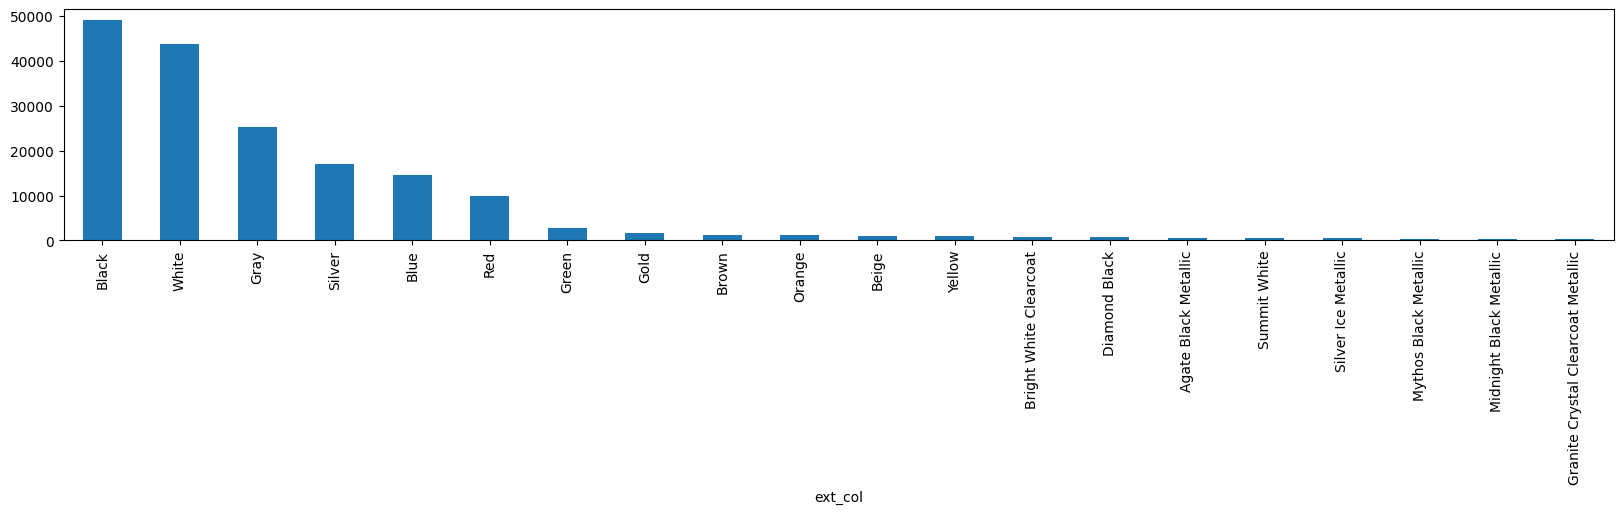

In [68]:
ext_col_freq=train_df.ext_col.value_counts()
ext_col_freq.nlargest(20).plot.bar(figsize=(20,3))

<Axes: xlabel='int_col'>

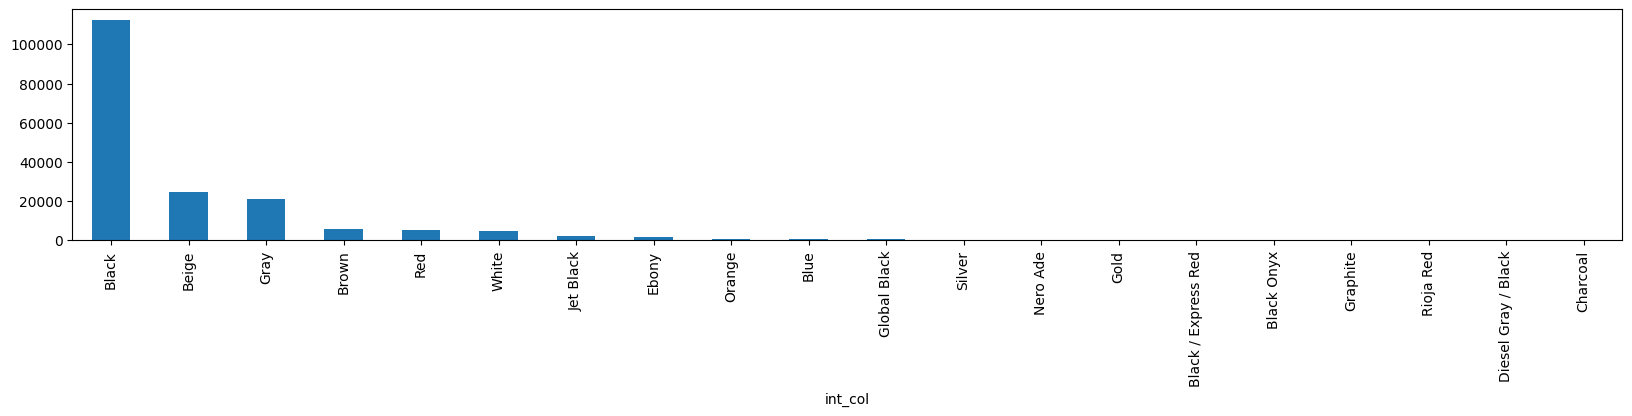

In [69]:
int_col_freq=train_df.int_col.value_counts()
int_col_freq.nlargest(20).plot.bar(figsize=(20,3))

In [70]:
ext_col_map1=train_df.groupby('brand_model')['ext_col'].agg(lambda x: x.mode()[0]).to_dict()
ext_col_map2=train_df['ext_col'].agg(lambda x: x.mode()[0])
int_col_map1=train_df.groupby('brand_model')['int_col'].agg(lambda x: x.mode()[0]).to_dict()
int_col_map2=train_df['int_col'].agg(lambda x: x.mode()[0])

##### Filling up missing values in 'accident' and 'clean_title' columns

In [71]:
train_df.loc[train_df['accident'].isnull(),'accident']=train_df[train_df['accident'].notnull()]['accident'].mode()[0]
train_df.loc[train_df['clean_title'].isnull(),'clean_title']=train_df[train_df['clean_title'].notnull()]['clean_title'].mode()[0]

In [72]:
#train_df.head(5)

In [73]:
train_df.isnull().sum()/len(train_df)*100

brand               0.00
model               0.00
model_year          0.00
milage              0.00
fuel_type           0.00
engine              0.49
transmission        0.05
ext_col             0.00
int_col             0.00
accident            0.00
clean_title         0.00
price               0.00
brand_model         0.00
car_age             0.00
engine_hp           0.00
engine_liter        0.00
engine_cylinder     0.00
transmission_type   0.00
dtype: float64

In [74]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              188533 non-null  object 
 1   model              188533 non-null  object 
 2   model_year         188533 non-null  int64  
 3   milage             188533 non-null  int64  
 4   fuel_type          188533 non-null  object 
 5   engine             187608 non-null  object 
 6   transmission       188446 non-null  object 
 7   ext_col            188533 non-null  object 
 8   int_col            188533 non-null  object 
 9   accident           188533 non-null  object 
 10  clean_title        188533 non-null  object 
 11  price              188533 non-null  int64  
 12  brand_model        188533 non-null  object 
 13  car_age            188533 non-null  int64  
 14  engine_hp          188533 non-null  float64
 15  engine_liter       188533 non-null  float64
 16  engine_

In [75]:
train_df.nunique()

brand                  57
model                1897
model_year             34
milage               6651
fuel_type               5
engine               1116
transmission           51
ext_col               318
int_col               155
accident                2
clean_title             1
price                1569
brand_model          3555
car_age                34
engine_hp             348
engine_liter           62
engine_cylinder         8
transmission_type       3
dtype: int64

#### Data distribution of independent variables

In [76]:
train_df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'brand_model', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'transmission_type'],
      dtype='object')

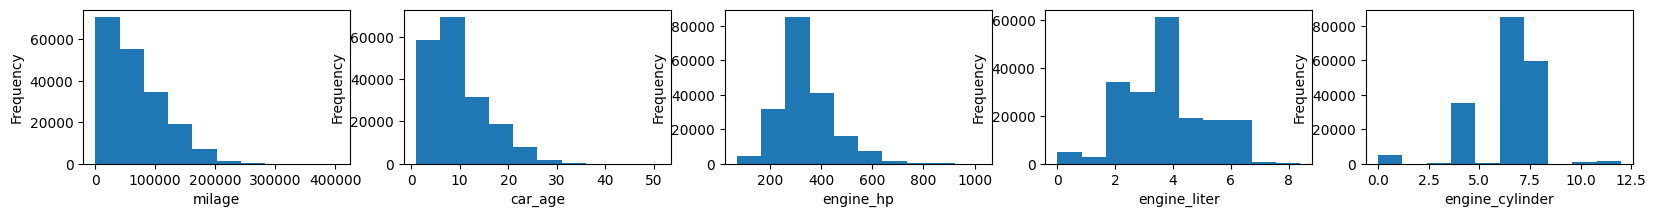

<Figure size 640x480 with 0 Axes>

In [77]:
column_list=['milage', 'car_age', 'engine_hp', 'engine_liter', 'engine_cylinder']
nrows=1
ncols=5
fig,subplt=plt.subplots(nrows,ncols,figsize=(20,2))

for n,col in zip(range(0,len(column_list)),column_list):
    train_df[col].plot.hist(ax=subplt[n])#,bins=100)
    #sns.boxplot(data=train_df,x=col,orient='h',ax=subplt[0,n])
    subplt[n].set_xlabel(col)


plt.show()
plt.tight_layout()

#### Visual Exploration of Correlation with Target Variable 'price'

##### Scatter plot of 'price' with numeric variables

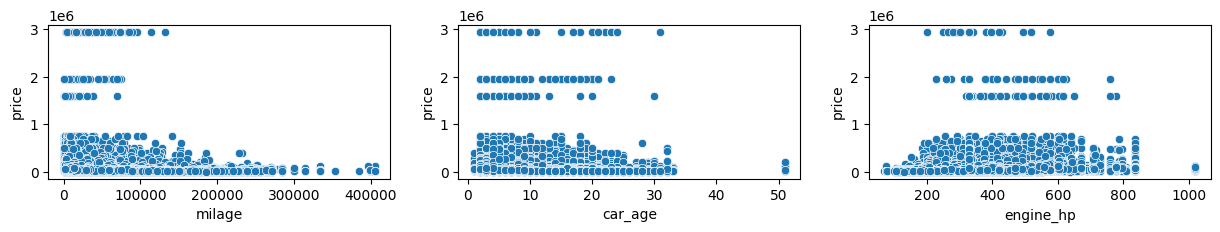

<Figure size 640x480 with 0 Axes>

In [78]:
column_list=['milage', 'car_age', 'engine_hp']
nrows=1
ncols=3
fig,subplt=plt.subplots(nrows,ncols,figsize=(15,2))

for n,col in zip(range(0,len(column_list)),column_list):
    sns.scatterplot(data=train_df,x=col,y='price',ax=subplt[n])
    subplt[n].set_xlabel(col,fontsize=10)
    #subplt[n].set_xparam(rotation=45)
    
plt.show()
plt.tight_layout()

##### Box plot of low cardinality variables

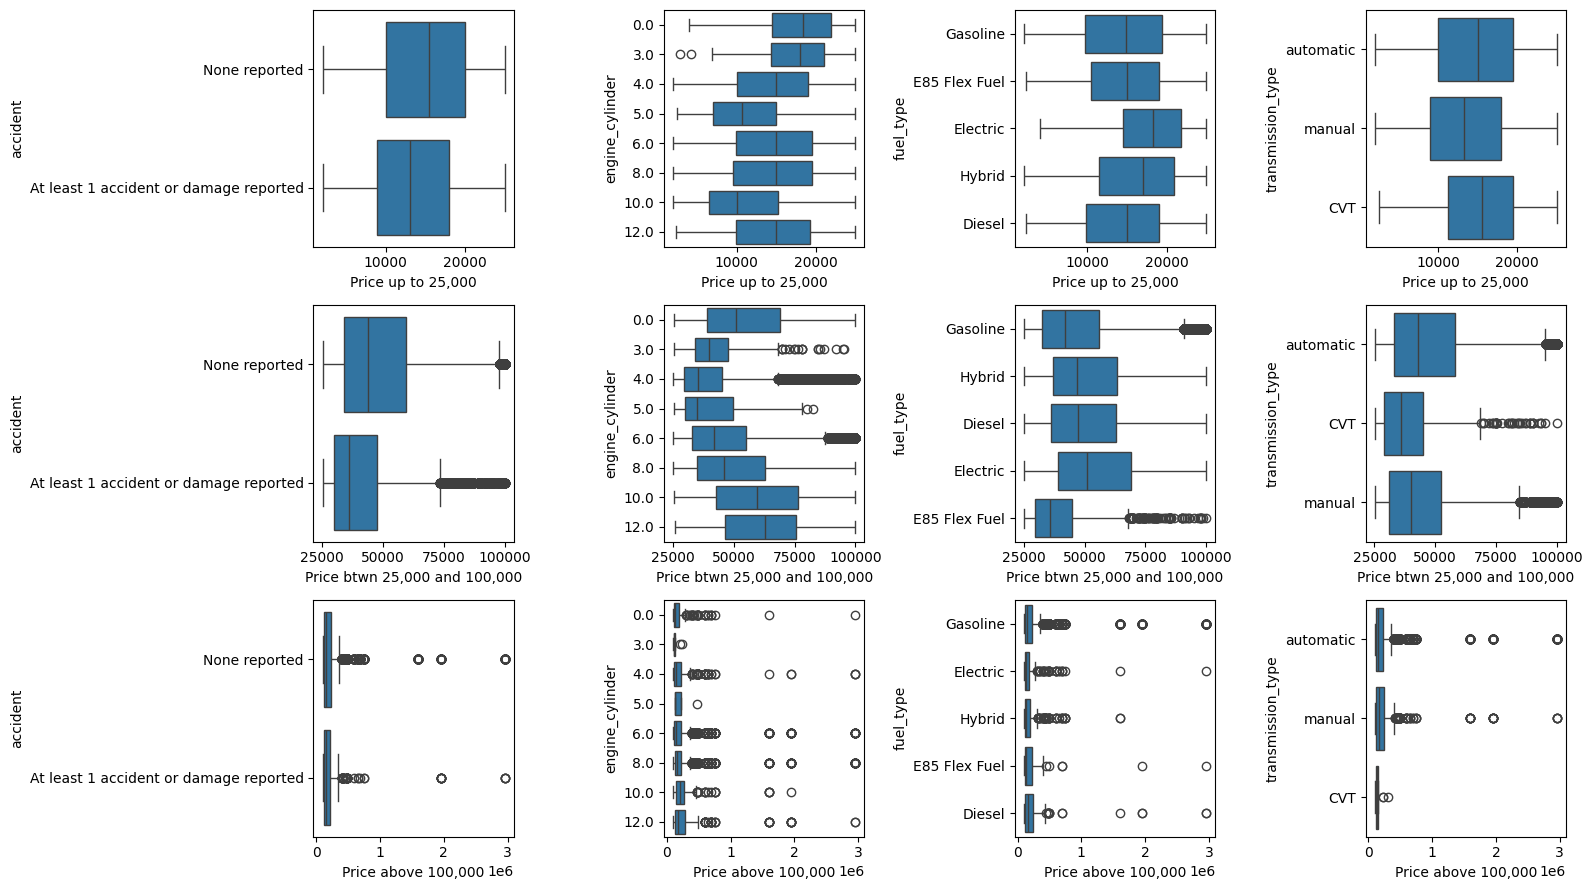

In [79]:
column_list=['accident', 'engine_cylinder', 'fuel_type', 'transmission_type']
nrows=3
ncols=4
fig,subplt=plt.subplots(nrows,ncols,figsize=(16,9))
for n,col in zip(range(0,len(column_list)),column_list):
    sns.boxplot(data=train_df[train_df['price']<=25000],y=col,x='price',orient='h',ax=subplt[0,n])
    subplt[0,n].set_xlabel('Price up to 25,000')

for n,col in zip(range(0,len(column_list)),column_list):
    sns.boxplot(data=train_df[(train_df['price'] > 25000) & (train_df['price'] <= 100000)],y=col,x='price',orient='h',ax=subplt[1,n])
    subplt[1,n].set_xlabel('Price btwn 25,000 and 100,000')

for n,col in zip(range(0,len(column_list)),column_list):
    sns.boxplot(data=train_df[(train_df['price'] > 100000)],y=col,x='price',orient='h',ax=subplt[2,n])
    subplt[2,n].set_xlabel('Price above 100,000')


plt.tight_layout()

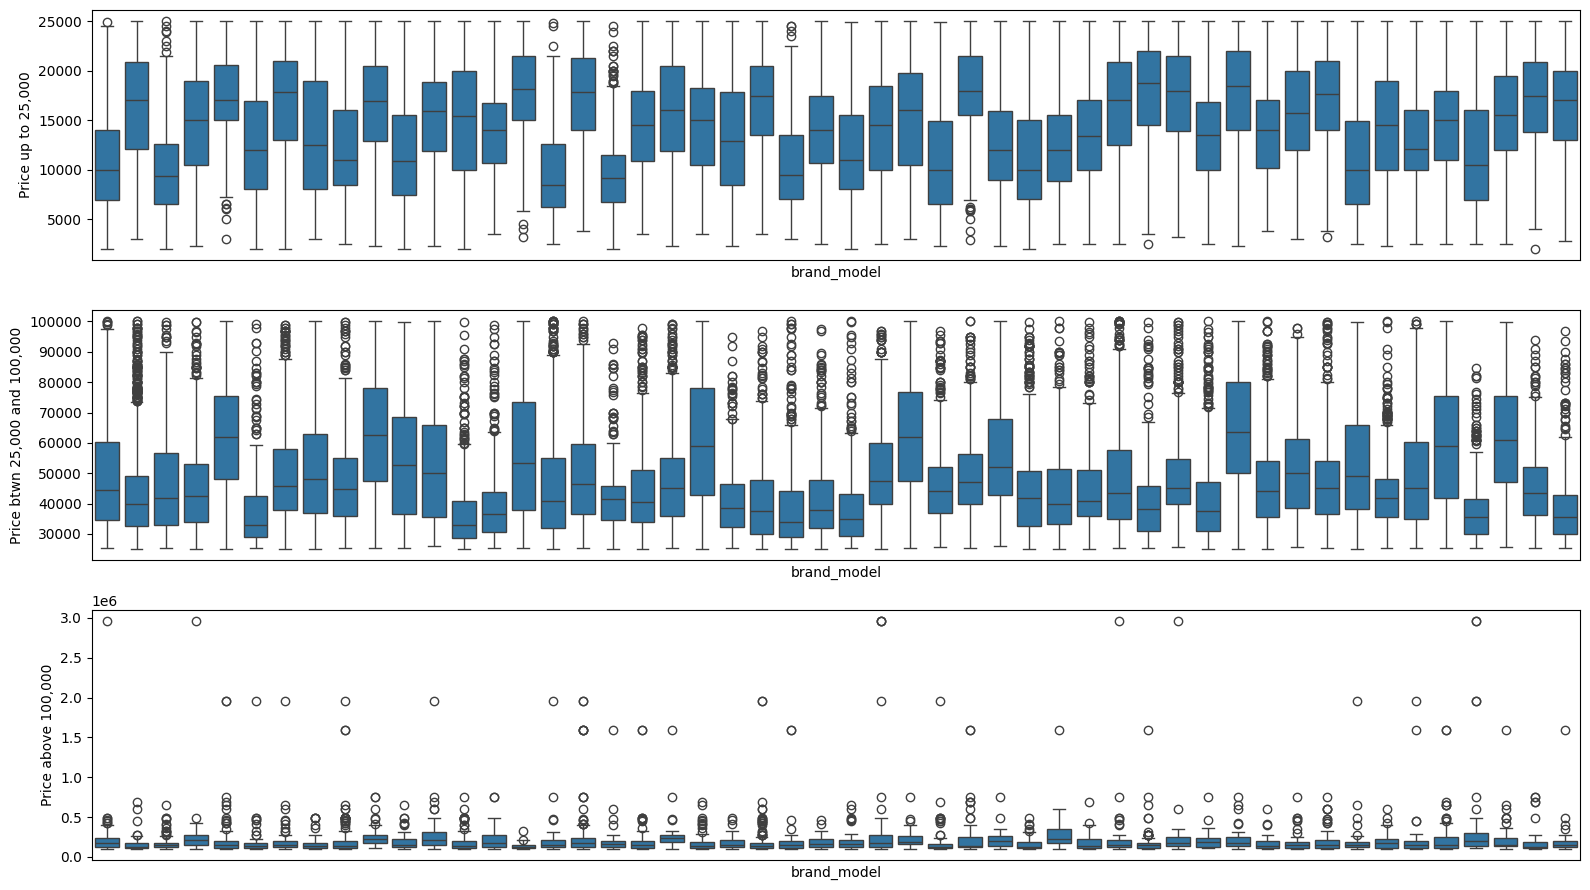

In [80]:
nrows=3
ncols=1
fig,subplt=plt.subplots(nrows,ncols,figsize=(16,9))

mask=train_df['price']<=25000
val_list=train_df[mask].brand_model.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(mask) & (train_df['brand_model'].isin(val_list))],
            x='brand_model',y='price',orient='v',ax=subplt[0])
subplt[0].tick_params(axis='x', length=0, labelbottom=False)
subplt[0].set_ylabel('Price up to 25,000')

mask=(train_df['price']>25000) & (train_df['price']<=100000)
val_list=train_df[mask].brand_model.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[mask & (train_df['brand_model'].isin(val_list))],
            x='brand_model',y='price',orient='v',ax=subplt[1])
subplt[1].tick_params(axis='x', length=0, labelbottom=False)
subplt[1].set_ylabel('Price btwn 25,000 and 100,000')

mask=train_df['price']>100000
val_list=train_df[train_df['price']>100000].brand_model.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(mask) & (train_df['brand_model'].isin(val_list))],
            x='brand_model',y='price',orient='v',ax=subplt[2])
subplt[2].tick_params(axis='x', length=0, labelbottom=False)
subplt[2].set_ylabel('Price above 100,000')

plt.tight_layout()
plt.show()

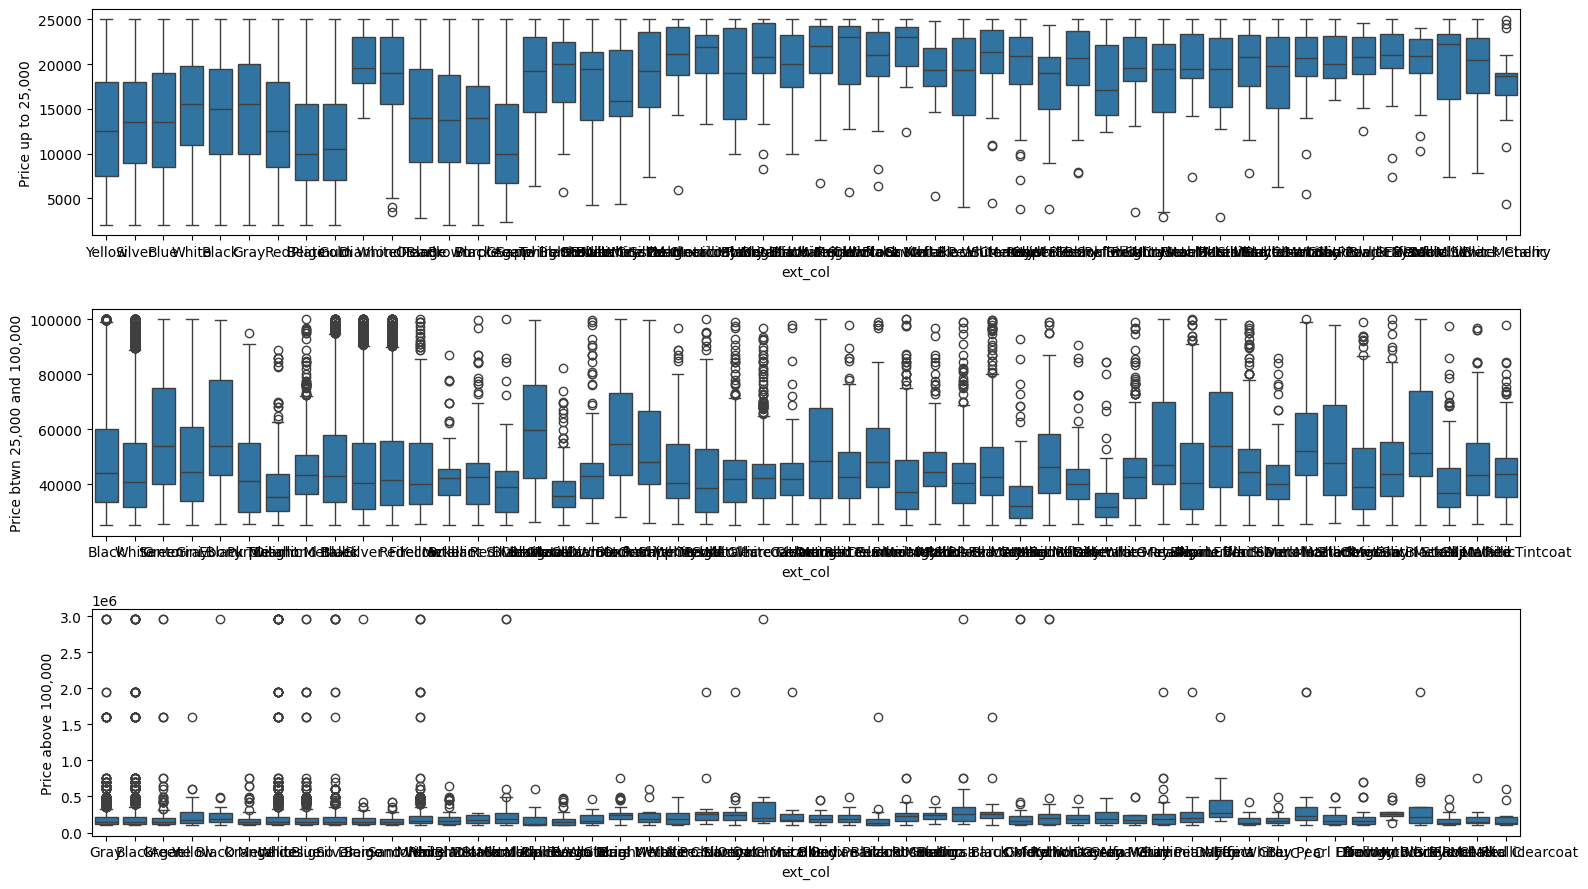

In [81]:
nrows=3
ncols=1
fig,subplt=plt.subplots(nrows,ncols,figsize=(16,9))

val_list=train_df[train_df['price']<=25000].ext_col.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(train_df['price']<=25000) & (train_df['ext_col'].isin(val_list))],
            x='ext_col',y='price',orient='v',ax=subplt[0])
subplt[0].set_ylabel('Price up to 25,000')

val_list=train_df[(train_df['price']>25000) & (train_df['price']<=100000)].ext_col.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(train_df['price']>25000) & (train_df['price']<=100000) & (train_df['ext_col'].isin(val_list))],
            x='ext_col',y='price',orient='v',ax=subplt[1])
subplt[1].set_ylabel('Price btwn 25,000 and 100,000')

val_list=train_df[train_df['price']>100000].ext_col.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(train_df['price']>100000) & (train_df['ext_col'].isin(val_list))],
            x='ext_col',y='price',orient='v',ax=subplt[2])
subplt[2].set_ylabel('Price above 100,000')

plt.tight_layout()
plt.show()

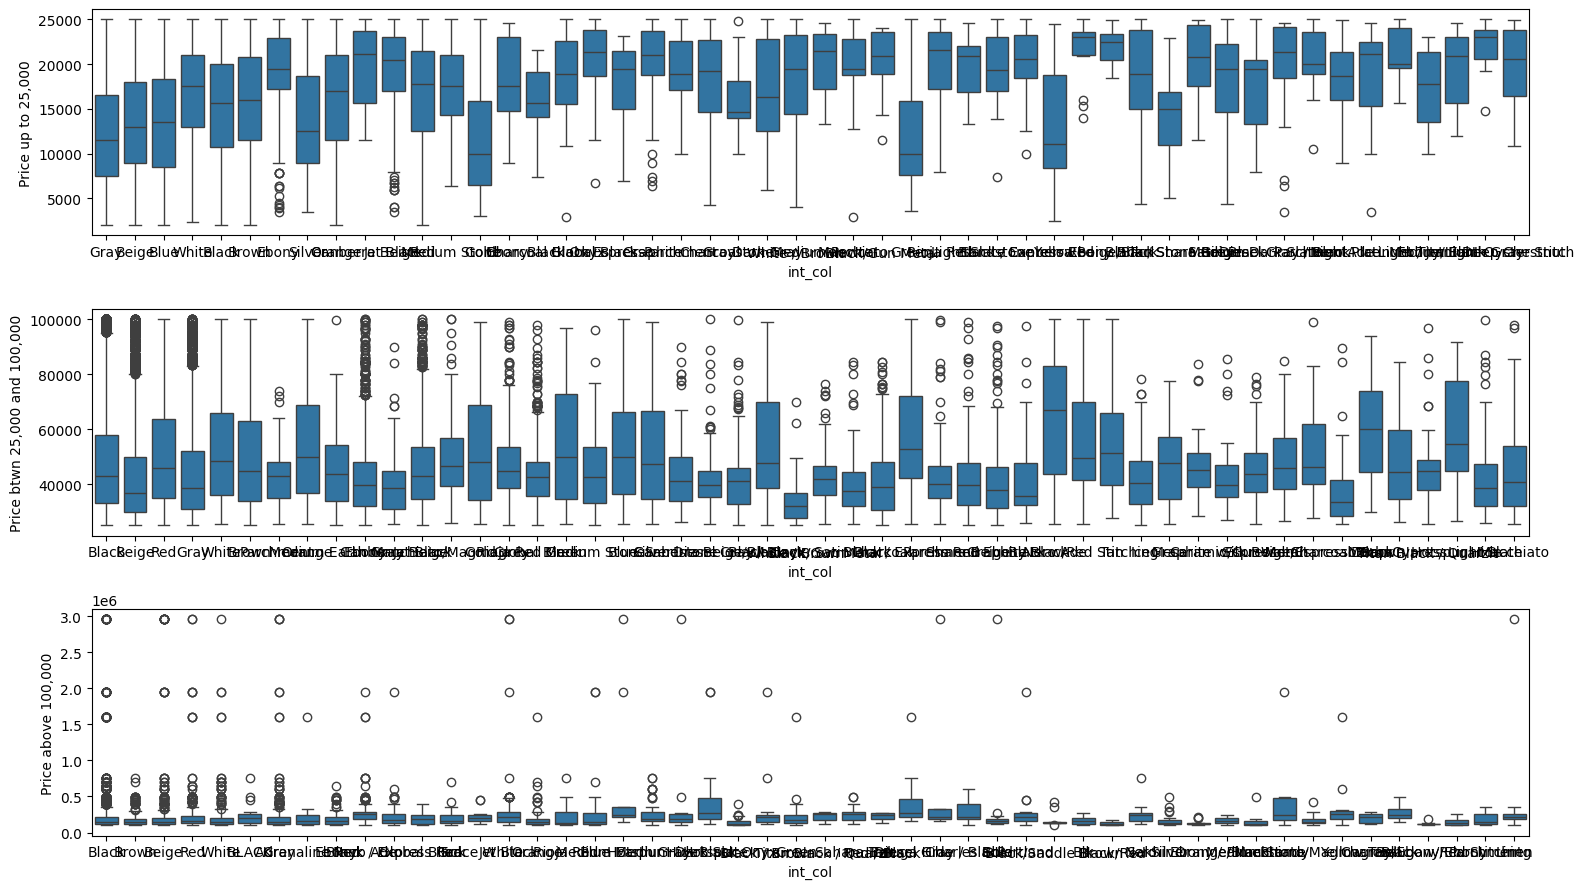

In [82]:
nrows=3
ncols=1
fig,subplt=plt.subplots(nrows,ncols,figsize=(16,9))

val_list=train_df[train_df['price']<=25000].int_col.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(train_df['price']<=25000) & (train_df['int_col'].isin(val_list))],
            x='int_col',y='price',orient='v',ax=subplt[0])
subplt[0].set_ylabel('Price up to 25,000')

val_list=train_df[(train_df['price']>25000) & (train_df['price']<=100000)].int_col.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(train_df['price']>25000) & (train_df['price']<=100000) & (train_df['int_col'].isin(val_list))],
            x='int_col',y='price',orient='v',ax=subplt[1])
subplt[1].set_ylabel('Price btwn 25,000 and 100,000')

val_list=train_df[train_df['price']>100000].int_col.value_counts().nlargest(50).keys()
#sns.boxplot(data=train_df[train_df['brand_model'].isin(train_df.groupby('brand_model')['price'].median().nsmallest(20).keys())],x='brand_model',y='price',orient='v')
sns.boxplot(data=train_df[(train_df['price']>100000) & (train_df['int_col'].isin(val_list))],
            x='int_col',y='price',orient='v',ax=subplt[2])
subplt[2].set_ylabel('Price above 100,000')

plt.tight_layout()
plt.show()

### Statistical Exploration of Correlation with Target Variable

##### Heat map using person correlation among numerical variables and Target Variable- price. Person correlation is good for finding linear relationship between two variables.

In [83]:
train_df.select_dtypes(exclude='object').columns.to_list()

['model_year',
 'milage',
 'price',
 'car_age',
 'engine_hp',
 'engine_liter',
 'engine_cylinder']

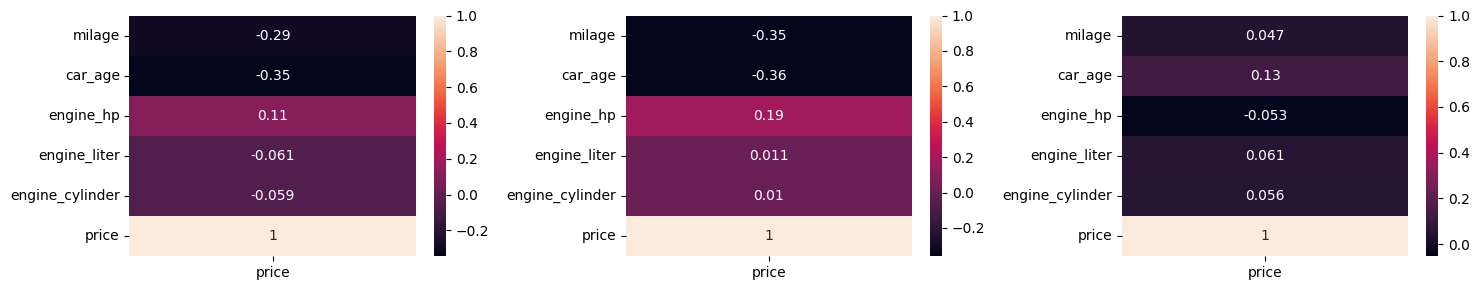

In [84]:
column_list=['milage','car_age','engine_hp','engine_liter','engine_cylinder','price']
corr1=train_df[train_df['price']<=15000][column_list].corr()
corr2=train_df[(train_df['price']>15000) & (train_df['price']<=30000)][column_list].corr()
corr3=train_df[train_df['price']>100000][column_list].corr()
fig,subplt=plt.subplots(1,3,figsize=(15,3))
sns.heatmap(corr1[['price']],annot=True, ax=subplt[0])
sns.heatmap(corr2[['price']],annot=True, ax=subplt[1])
sns.heatmap(corr3[['price']],annot=True, ax=subplt[2])
plt.tight_layout()

##### Using Spearman's Rank Correlation to find if any non-linear relationship exists

In [85]:
column_list=['milage','car_age','engine_hp','engine_liter','engine_cylinder','price']

print("When Price below 25000: \n")
for col in column_list:
    corr, _ = spearmanr(train_df[train_df['price']<=25000][col], train_df[train_df['price']<=25000]['price'])
    print(f"Spearman's Rank between {col} and price: {corr:.3f}")
print("\n")

print("When Price between 25,000 and 100,000: \n")
for col in column_list:
    corr, _ = spearmanr(train_df[(train_df['price']>25000) & (train_df['price']<=100000)][col], 
                        train_df[(train_df['price']>25000) & (train_df['price']<=100000)]['price'])
    print(f"Spearman's Rank between {col} and price: {corr:.3f}")
print("\n")

print("When Price above 100,000: \n")
for col in column_list:
    corr, _ = spearmanr(train_df[train_df['price']>100000][col], train_df[train_df['price']>100000]['price'])
    print(f"Spearman's Rank between {col} and price: {corr:.3f}")
print("\n")

When Price below 25000: 

Spearman's Rank between milage and price: -0.513
Spearman's Rank between car_age and price: -0.575
Spearman's Rank between engine_hp and price: 0.282
Spearman's Rank between engine_liter and price: -0.038
Spearman's Rank between engine_cylinder and price: -0.016
Spearman's Rank between price and price: 1.000


When Price between 25,000 and 100,000: 

Spearman's Rank between milage and price: -0.469
Spearman's Rank between car_age and price: -0.392
Spearman's Rank between engine_hp and price: 0.320
Spearman's Rank between engine_liter and price: 0.122
Spearman's Rank between engine_cylinder and price: 0.154
Spearman's Rank between price and price: 1.000


When Price above 100,000: 

Spearman's Rank between milage and price: -0.005
Spearman's Rank between car_age and price: 0.080
Spearman's Rank between engine_hp and price: -0.105
Spearman's Rank between engine_liter and price: 0.095
Spearman's Rank between engine_cylinder and price: 0.092
Spearman's Rank betwee

##### ANOVA test to find correlation between categorical variables and Target Variable- 'price'

In [86]:
train_df.select_dtypes(exclude=['int','float']).columns.to_list()

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'brand_model',
 'transmission_type']

##### ANOVA Test using f_oneway from scipy.stats

In [87]:
column_list=['fuel_type', 'ext_col', 'int_col', 'accident', 'brand_model', 'transmission_type']

print("When Price below 25,000: \n")
for col in column_list:
    grpdata=train_df[train_df['price']<=25000].groupby([col])['price'].apply(list)
    anova_results=f_oneway(*grpdata)
    print(f"'price' vs. {col}: p-value = {anova_results[1]}") 
    
    #if anova_results[1]<0.5:
    #    print(col," is correlated with target variable; P-Value:", anova_results[1])
    #else:
    #    print(col," is NOT correlated with target variable; P-Value:", anova_results[1]) 
print("\n")

print("When Price between 25,000 and 100,000: \n")
for col in column_list:
    grpdata=train_df[(train_df['price']>15000) & (train_df['price']<=30000)].groupby([col])['price'].apply(list)
    anova_results=f_oneway(*grpdata)
    print(f"'price' vs. {col}: p-value = {anova_results[1]}") 
    
    #if anova_results[1]<0.5:
    #    print(col," is correlated with target variable; P-Value:", anova_results[1])
    #else:
    #    print(col," is NOT correlated with target variable; P-Value:", anova_results[1]) 
print("\n")


print("When Price above 100,000: \n")
for col in column_list:
    grpdata=train_df[train_df['price']>100000].groupby([col])['price'].apply(list)
    anova_results=f_oneway(*grpdata)
    print(f"'price' vs. {col}: p-value = {anova_results[1]}") 
    
    #if anova_results[1]<0.5:
    #    print(col," is correlated with target variable; P-Value:", anova_results[1])
    #else:
    #    print(col," is NOT correlated with target variable; P-Value:", anova_results[1]) 
print("\n")

When Price below 25,000: 

'price' vs. fuel_type: p-value = 9.801920215040673e-57
'price' vs. ext_col: p-value = 0.0
'price' vs. int_col: p-value = 0.0
'price' vs. accident: p-value = 6.705901741431685e-247
'price' vs. brand_model: p-value = 0.0
'price' vs. transmission_type: p-value = 3.6237872955053563e-56


When Price between 25,000 and 100,000: 

'price' vs. fuel_type: p-value = 9.837057213145909e-64
'price' vs. ext_col: p-value = 8.30619873738246e-217
'price' vs. int_col: p-value = 8.44526784640874e-143
'price' vs. accident: p-value = 1.1836672465739099e-116
'price' vs. brand_model: p-value = 0.0
'price' vs. transmission_type: p-value = 4.536025579682111e-53


When Price above 100,000: 

'price' vs. fuel_type: p-value = 0.0003043260591737303
'price' vs. ext_col: p-value = 4.724957278215112e-05
'price' vs. int_col: p-value = 3.247271633533131e-27
'price' vs. accident: p-value = 0.12503261985922876
'price' vs. brand_model: p-value = 1.952508805125305e-118
'price' vs. transmission_ty

##### I am using f_regression from sklearn.feature_selection to find correlation between low cardinality variables. For high cardinality variables, this may not be suitable. Since the method uses label encoder, which may render high range of numeric variables due to very high cardinality, may influence the outcome of the method.

In [88]:
column_list=['milage','car_age','engine_hp','engine_liter','engine_cylinder','fuel_type', 'accident', 'transmission_type']

for col in column_list:
    #print(col)
    if train_df[col].dtype=='object':
        #f_vals, p_vals=f_regression(pd.get_dummies(train_modified[col],dtype=int),train_modified['log_price'])
        f_vals, p_vals = f_regression(train_df[[col]].apply(LabelEncoder().fit_transform),train_df['price'])
        if p_vals < 0.05:
            print(col," is correlated with price; p-value=", p_vals)
        else:
            print(col," is NOT correlated with price; p-value=", p_vals)
    else:
        f_vals, p_vals=f_regression(train_df[[col]],train_df['price'])
        if p_vals < 0.05:
            print(col," is correlated with price; p-value=", p_vals)
        else:
            print(col," is NOT correlated with price; p-value=", p_vals)
print("\n")

milage  is correlated with price; p-value= [0.]
car_age  is correlated with price; p-value= [0.]
engine_hp  is correlated with price; p-value= [0.]
engine_liter  is correlated with price; p-value= [5.66409042e-199]
engine_cylinder  is correlated with price; p-value= [0.]
fuel_type  is correlated with price; p-value= [1.96098756e-09]
accident  is correlated with price; p-value= [0.]
transmission_type  is correlated with price; p-value= [5.41083757e-28]




##### I am using Mutual Info Regression from sklearn.feature_selection to find importance of numeric variables and low cardinality variables w.r.t. 'price'. For high cardinality variables, this may not be suitable. Since the method uses label encoder, which may render high range of numeric variables due to very high cardinality, may influence the outcome of the method. 

In [89]:
column_list=['milage','car_age','engine_hp','engine_liter','engine_cylinder','fuel_type', 'accident', 'transmission_type']
mi_score_df=pd.DataFrame(columns=['price_range','column','mi_score'])

print("When Price below 25,000: \n")
for col in column_list:
    if train_df[col].dtype=='object':
        mi_scores=mutual_info_regression(train_df[train_df['price']<=25000][[col]].apply(LabelEncoder().fit_transform),
                                             train_df[train_df['price']<=25000]['price'],discrete_features=True)
        print("mi-score of", col, "w.r.t. 'price': ", mi_scores)
    else:
        mi_scores=mutual_info_regression(train_df[train_df['price']<=25000][[col]],
                                             train_df[train_df['price']<=25000]['price'])
        print("mi-score of", col, "w.r.t. 'price': ", mi_scores)
print("\n")

print("When Price between 25,000 and 100,000: \n")
for col in column_list:
    if train_df[col].dtype=='object':
        mi_scores=mutual_info_regression(train_df[(train_df['price']>25000) & (train_df['price']<=100000)][[col]].apply(LabelEncoder().fit_transform),
                                             train_df[(train_df['price']>25000) & (train_df['price']<=100000)]['price'],discrete_features=True)
        print("mi-score of", col, "w.r.t. 'price': ", mi_scores)
    else:
        mi_scores=mutual_info_regression(train_df[(train_df['price']>25000) & (train_df['price']<=100000)][[col]],
                                             train_df[(train_df['price']>25000) & (train_df['price']<=100000)]['price'])
        print("mi-score of", col, "w.r.t. 'price': ", mi_scores)
print("\n")

print("When Price above 100,000: \n")
for col in column_list:
    if train_df[col].dtype=='object':
        mi_scores=mutual_info_regression(train_df[train_df['price']>100000][[col]].apply(LabelEncoder().fit_transform),
                                             train_df[train_df['price']>100000]['price'],discrete_features=True)
        print("mi-score of", col, "w.r.t. 'price': ", mi_scores)
    else:
        mi_scores=mutual_info_regression(train_df[train_df['price']>100000][[col]],
                                             train_df[train_df['price']>100000]['price'])
        print("mi-score of", col, "w.r.t. 'price': ", mi_scores)
print("\n")

When Price below 25,000: 

mi-score of milage w.r.t. 'price':  [0.39960412]
mi-score of car_age w.r.t. 'price':  [0.31187287]
mi-score of engine_hp w.r.t. 'price':  [0.20886303]
mi-score of engine_liter w.r.t. 'price':  [0.06792115]
mi-score of engine_cylinder w.r.t. 'price':  [0.0144112]
mi-score of fuel_type w.r.t. 'price':  [0.00517363]
mi-score of accident w.r.t. 'price':  [0.01895162]
mi-score of transmission_type w.r.t. 'price':  [0.00591548]


When Price between 25,000 and 100,000: 

mi-score of milage w.r.t. 'price':  [0.33842848]
mi-score of car_age w.r.t. 'price':  [0.22322386]
mi-score of engine_hp w.r.t. 'price':  [0.39564556]
mi-score of engine_liter w.r.t. 'price':  [0.18203642]
mi-score of engine_cylinder w.r.t. 'price':  [0.07377931]
mi-score of fuel_type w.r.t. 'price':  [0.02426584]
mi-score of accident w.r.t. 'price':  [0.0235451]
mi-score of transmission_type w.r.t. 'price':  [0.01090617]


When Price above 100,000: 

mi-score of milage w.r.t. 'price':  [0.13864408]

#### Encoding cardinal variables

##### The independent variables brand-model, ext_col and int_col have very high cardinality. And 'fuel_type' and 'transmission_type' have high variance in terms of frequency of occurance. 
##### Hence, I am replacing these independent variables with the median of price for respective groups, multiplied with a smoothing factor.

In [90]:
train_df['log_price']=np.log(train_df['price'])

In [91]:
global_median=train_df['log_price'].median()
global_count=len(train_df)

for col in ['brand_model','ext_col','int_col','fuel_type','transmission_type']:

    group_count=train_df.groupby(col)['log_price'].size()
    group_median=train_df.groupby(col)['log_price'].median()

    smoothing_factor=1/(1 + np.exp((50 - group_count)/100))    
    encoded_val=smoothing_factor*group_median + (1 - smoothing_factor)*global_median

    train_df[f'{col}_score'] = train_df[col].map(encoded_val)

In [92]:
brand_model_score_map=train_df.groupby('brand_model')['brand_model_score'].median().to_dict()
ext_col_score_map=train_df.groupby('ext_col')['ext_col_score'].median().to_dict()
int_col_score_map=train_df.groupby('int_col')['int_col_score'].median().to_dict()
fuel_type_score_map=train_df.groupby('fuel_type')['fuel_type_score'].median().to_dict()
transmission_type_score_map=train_df.groupby('transmission_type')['transmission_type_score'].median().to_dict()

train_global_median=train_df['log_price'].median()


In [93]:
def accident_encoder(df):
    df=df.copy()
    df['accident']=np.where(df['accident']=='None reported',1,0)
    return df

accident_fixer=FunctionTransformer(accident_encoder,validate=False)

In [94]:
train_df=accident_encoder(train_df)

##### Checking the mi_score to assess the importance of transformed columns against target variable 'price'.

In [95]:
print("\n When Price below 25,000: \n")
mask=train_df['price']<=25000
print("mi-score for 'brand_model_score':", mutual_info_regression(train_df[mask][['brand_model_score']],train_df[mask]['price']))
print("mi-score for 'ext_col_score':", mutual_info_regression(train_df[mask][['ext_col_score']],train_df[mask]['price']))
print("mi-score for 'int_col_score':", mutual_info_regression(train_df[mask][['int_col_score']],train_df[mask]['price']))
print("mi-score for 'fuel_type_score':", mutual_info_regression(train_df[mask][['fuel_type_score']],train_df[mask]['price']))
print("mi-score for 'transmission_type_score':", mutual_info_regression(train_df[mask][['transmission_type_score']],train_df[mask]['price']))

print("\n When Price between 25,000 and 1,00,000: \n")
mask=(train_df['price']>25000) & (train_df['price']<=100000)
print("mi-score for 'brand_model_score':", mutual_info_regression(train_df[mask][['brand_model_score']],train_df[mask]['price']))
print("mi-score for 'ext_col_score':", mutual_info_regression(train_df[mask][['ext_col_score']],train_df[mask]['price']))
print("mi-score for 'int_col_score':", mutual_info_regression(train_df[mask][['int_col_score']],train_df[mask]['price']))
print("mi-score for 'fuel_type_score':", mutual_info_regression(train_df[mask][['fuel_type_score']],train_df[mask]['price']))
print("mi-score for 'transmission_type_score':", mutual_info_regression(train_df[mask][['transmission_type_score']],train_df[mask]['price']))

print("\n When Price above 1,00,000: \n")
mask=train_df['price']>100000
print("mi-score for 'brand_model_score':", mutual_info_regression(train_df[mask][['brand_model_score']],train_df[mask]['price']))
print("mi-score for 'ext_col_score':", mutual_info_regression(train_df[mask][['ext_col_score']],train_df[mask]['price']))
print("mi-score for 'int_col_score':", mutual_info_regression(train_df[mask][['int_col_score']],train_df[mask]['price']))
print("mi-score for 'fuel_type_score':", mutual_info_regression(train_df[mask][['fuel_type_score']],train_df[mask]['price']))
print("mi-score for 'transmission_type_score':", mutual_info_regression(train_df[mask][['transmission_type_score']],train_df[mask]['price']))


 When Price below 25,000: 

mi-score for 'brand_model_score': [0.19139875]
mi-score for 'ext_col_score': [0.053664]
mi-score for 'int_col_score': [0.05399282]
mi-score for 'fuel_type_score': [0.00126655]
mi-score for 'transmission_type_score': [0.00430422]

 When Price between 25,000 and 1,00,000: 

mi-score for 'brand_model_score': [0.26375733]
mi-score for 'ext_col_score': [0.11749321]
mi-score for 'int_col_score': [0.09039579]
mi-score for 'fuel_type_score': [0.02729029]
mi-score for 'transmission_type_score': [0.01003944]

 When Price above 1,00,000: 

mi-score for 'brand_model_score': [0.14214126]
mi-score for 'ext_col_score': [0.09687659]
mi-score for 'int_col_score': [0.07039842]
mi-score for 'fuel_type_score': [0.0131435]
mi-score for 'transmission_type_score': [0]


In [96]:
train_df.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_hp,engine_liter,engine_cylinder,transmission_type,log_price,brand_model_score,ext_col_score,int_col_score,fuel_type_score,transmission_type_score
id,,,,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,1,...,172.00,1.60,4.00,automatic,8.34,9.27,10.18,9.77,10.31,10.37
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,0,...,252.00,3.90,8.00,automatic,8.52,9.82,9.90,9.89,10.31,10.37
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,1,...,320.00,5.30,8.00,automatic,9.54,10.15,10.31,9.77,9.90,10.37


In [97]:
train_df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'brand_model', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'transmission_type', 'log_price',
       'brand_model_score', 'ext_col_score', 'int_col_score',
       'fuel_type_score', 'transmission_type_score'],
      dtype='object')

In [98]:
train_df.nunique()

brand                        57
model                      1897
model_year                   34
milage                     6651
fuel_type                     5
engine                     1116
transmission                 51
ext_col                     318
int_col                     155
accident                      2
clean_title                   1
price                      1569
brand_model                3555
car_age                      34
engine_hp                   348
engine_liter                 62
engine_cylinder               8
transmission_type             3
log_price                  1569
brand_model_score          2814
ext_col_score               317
int_col_score               155
fuel_type_score               5
transmission_type_score       3
dtype: int64

In [99]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   brand                    188533 non-null  object 
 1   model                    188533 non-null  object 
 2   model_year               188533 non-null  int64  
 3   milage                   188533 non-null  int64  
 4   fuel_type                188533 non-null  object 
 5   engine                   187608 non-null  object 
 6   transmission             188446 non-null  object 
 7   ext_col                  188533 non-null  object 
 8   int_col                  188533 non-null  object 
 9   accident                 188533 non-null  int32  
 10  clean_title              188533 non-null  object 
 11  price                    188533 non-null  int64  
 12  brand_model              188533 non-null  object 
 13  car_age                  188533 non-null  int64  
 14  engine_hp

### Drop unrequired columns

In [100]:
print("Original Columns: ",train_df.columns)

Original Columns:  Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'brand_model', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'transmission_type', 'log_price',
       'brand_model_score', 'ext_col_score', 'int_col_score',
       'fuel_type_score', 'transmission_type_score'],
      dtype='object')


In [101]:
selected_columns=[
'milage',
'accident',
'car_age',
'engine_hp',
'engine_liter',
'engine_cylinder',
'brand_model_score',
'ext_col_score',
'int_col_score',
'fuel_type_score',
'transmission_type_score',
'price'
]
print("Selected columns are: ",selected_columns)

Selected columns are:  ['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter', 'engine_cylinder', 'brand_model_score', 'ext_col_score', 'int_col_score', 'fuel_type_score', 'transmission_type_score', 'price']


In [102]:
train_modified=train_df[selected_columns]

In [103]:
train_modified.columns

Index(['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score', 'price'],
      dtype='object')

In [104]:
train_modified.isnull().sum()

milage                     0
accident                   0
car_age                    0
engine_hp                  0
engine_liter               0
engine_cylinder            0
brand_model_score          0
ext_col_score              0
int_col_score              0
fuel_type_score            0
transmission_type_score    0
price                      0
dtype: int64

In [105]:
train_modified.nunique()

milage                     6651
accident                      2
car_age                      34
engine_hp                   348
engine_liter                 62
engine_cylinder               8
brand_model_score          2814
ext_col_score               317
int_col_score               155
fuel_type_score               5
transmission_type_score       3
price                      1569
dtype: int64

In [106]:
train_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   milage                   188533 non-null  int64  
 1   accident                 188533 non-null  int32  
 2   car_age                  188533 non-null  int64  
 3   engine_hp                188533 non-null  float64
 4   engine_liter             188533 non-null  float64
 5   engine_cylinder          188533 non-null  float64
 6   brand_model_score        188533 non-null  float64
 7   ext_col_score            188533 non-null  float64
 8   int_col_score            188533 non-null  float64
 9   fuel_type_score          188533 non-null  float64
 10  transmission_type_score  188533 non-null  float64
 11  price                    188533 non-null  int64  
dtypes: float64(8), int32(1), int64(3)
memory usage: 22.0 MB


### Exploration and treatment of target variable 'price'

##### Line plot of 'price' value sorted

<Axes: ylabel='price'>

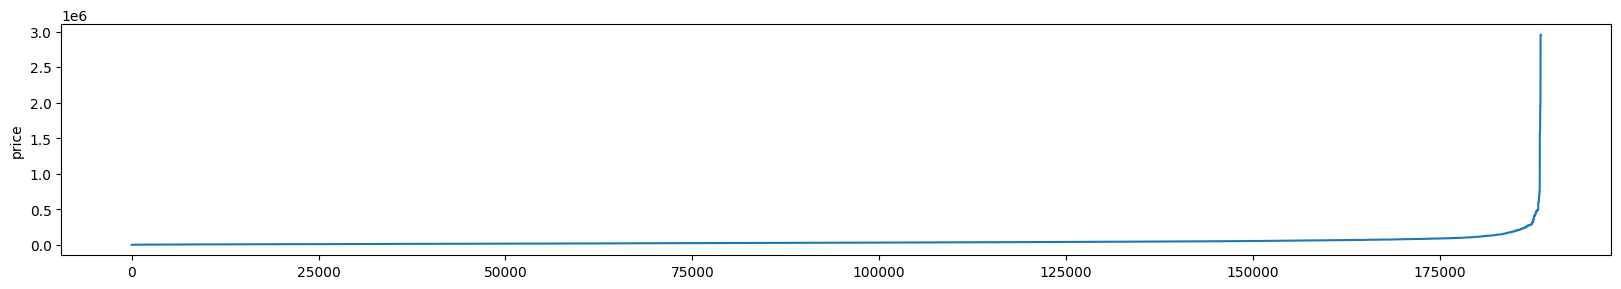

In [107]:
plt.figure(figsize=(20,3))
sns.lineplot(data=train_modified.sort_values(by='price'),x=np.arange(0,len(train_df),1) ,y='price')

<Axes: >

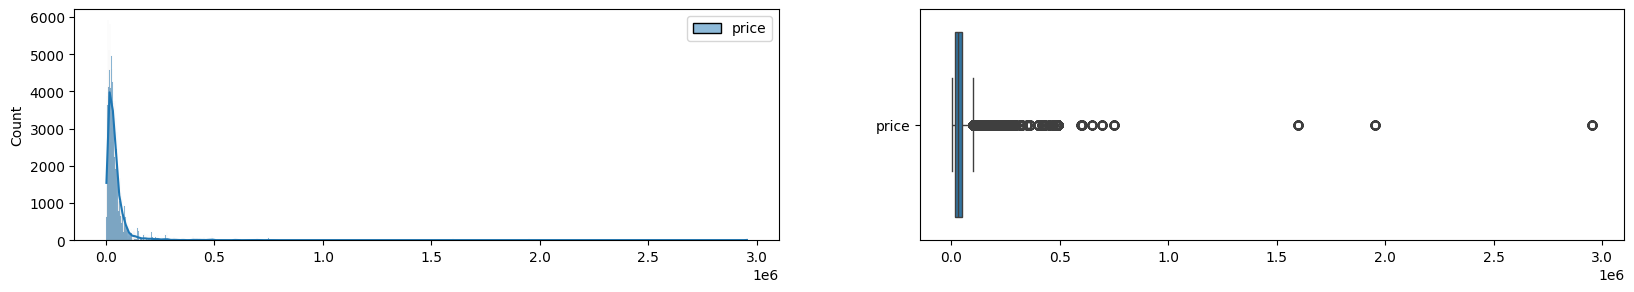

In [108]:
fig,subplt=plt.subplots(1,2,figsize=(20,3))
sns.histplot(data=train_modified[['price']],kde=True, ax=subplt[0])
sns.boxplot(train_modified[['price']],orient='h',ax=subplt[1])

##### Above distributions indicate car prices have significant outliers in the upper end. Hence, 
1. I am segmenting the data into three categories based on the price range
2. Using transformation of the 'price' values for smoothening the skewness.

##### Segmenting the data

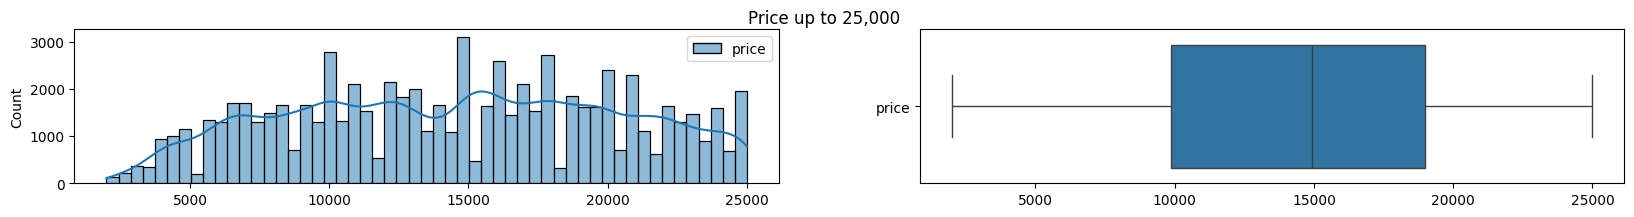

<Figure size 640x480 with 0 Axes>

In [109]:
fig,subplt=plt.subplots(1,2,figsize=(20,2))
sns.histplot(data=train_modified[train_modified['price']<25000][['price']],kde=True,ax=subplt[0])
sns.boxplot(data=train_modified[train_modified['price']<25000][['price']],orient='h',ax=subplt[1])
plt.suptitle("Price up to 25,000")
plt.show()
plt.tight_layout()

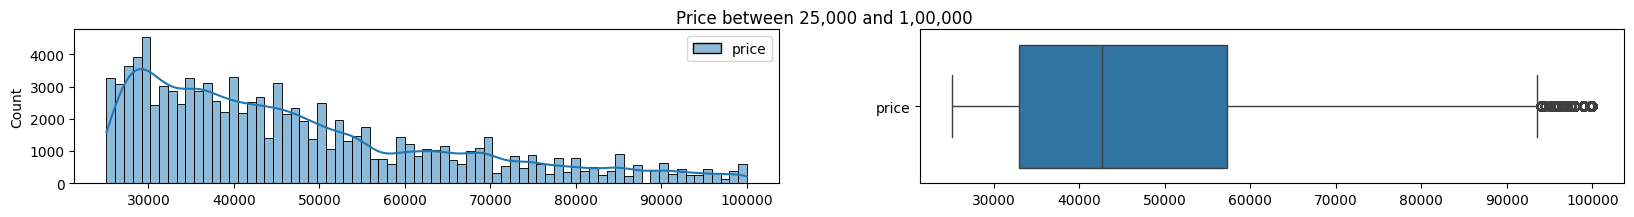

<Figure size 640x480 with 0 Axes>

In [110]:
fig,subplt=plt.subplots(1,2,figsize=(20,2))
sns.histplot(data=(train_modified[(train_modified['price']>25000) & (train_modified['price']<=100000)][['price']]),kde=True,ax=subplt[0])
sns.boxplot(data=train_modified[(train_modified['price']>25000) & (train_modified['price']<=100000)][['price']],orient='h',ax=subplt[1])
plt.suptitle("Price between 25,000 and 1,00,000")
plt.show()
plt.tight_layout()

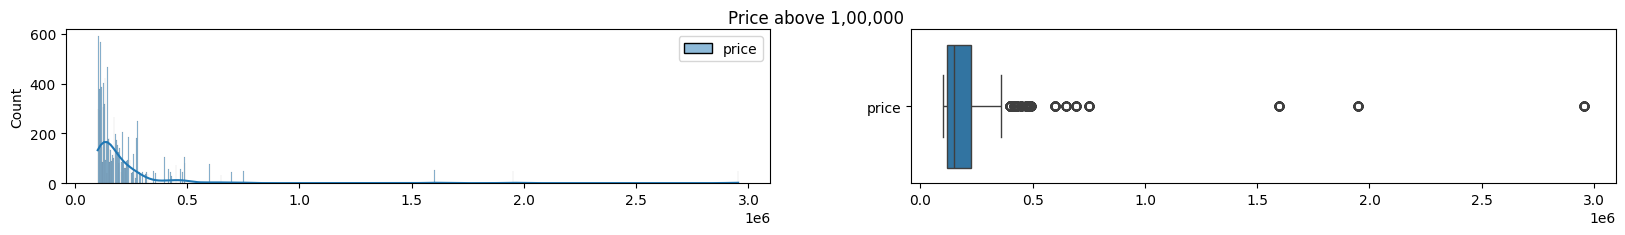

<Figure size 640x480 with 0 Axes>

In [111]:
fig,subplt=plt.subplots(1,2,figsize=(20,2))
sns.histplot(data=train_modified[(train_modified['price']>100000)][['price']],bins=1000, kde=True,ax=subplt[0])
sns.boxplot(data=train_modified[(train_modified['price']>100000)][['price']],orient='h',ax=subplt[1])
plt.suptitle("Price above 1,00,000")
plt.show()
plt.tight_layout()

In [112]:
def price_range (price):
    if price <= 25000:
        val=0
    elif price <= 100000:
        val=1
    else:
        val=2
    return val

train_modified['price_range']=train_modified['price'].apply(price_range)
#train_df.head(3)

C:\Users\priyamboda.ghosh\AppData\Local\Temp\ipykernel_9196\618604175.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_modified['price_range']=train_modified['price'].apply(price_range)


In [113]:
train_modified.groupby(['price_range']).size()

price_range
0     74987
1    103109
2     10437
dtype: int64

### Saving the dataset train_modified with segmentation

In [114]:
train_modified.to_pickle('C:/Users/priyamboda.ghosh/Desktop/Priyamboda-Personal/Personal/Data Science/ML Projects for Portfolio/Regression of Used Car Prices/train_modified_segmented.pkl')

### Classification model for finding 'price_range' for new data

In [115]:
train_modified=pd.read_pickle('C:/Users/priyamboda.ghosh/Desktop/Priyamboda-Personal/Personal/Data Science/ML Projects for Portfolio/Regression of Used Car Prices/train_modified_segmented.pkl')
train_modified.shape

(188533, 13)

In [116]:
train_modified['price_range'].value_counts().sort_index()

price_range
0     74987
1    103109
2     10437
Name: count, dtype: int64

In [117]:
train_modified.columns

Index(['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score', 'price',
       'price_range'],
      dtype='object')

In [118]:
classification_predictors = train_modified.columns.drop(['price','price_range'])
classification_target = 'price_range'

In [119]:
X=train_modified[classification_predictors].to_numpy()
y=train_modified[classification_target].to_numpy()

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

scaler=StandardScaler()
scalerfit=scaler.fit(X_train)
X_train=scalerfit.transform(X_train)
X_test=scalerfit.transform(X_test)

#### K-Nearest Neighbour Classification Model

In [361]:
Classification_Model=KNeighborsClassifier(n_neighbors=100)
y_pred=Classification_Model.fit(X_train, y_train).predict(X_test)

print("Confusion Matrix:\n", metrics.confusion_matrix(y_test,y_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_pred))
print("Accuracy Score:", metrics.accuracy_score(y_test,y_pred))

Confusion Matrix:
 [[12347  2704     2]
 [ 2224 18231    86]
 [   81  1891   141]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83     15053
           1       0.80      0.89      0.84     20541
           2       0.62      0.07      0.12      2113

    accuracy                           0.81     37707
   macro avg       0.75      0.59      0.60     37707
weighted avg       0.81      0.81      0.80     37707

Accuracy Score: 0.8146763200466757


#### Random Forest Classifier

In [362]:
Classification_Model=RandomForestClassifier(n_estimators=100,max_depth=20,criterion='gini',bootstrap=True,random_state=42)
y_pred=Classification_Model.fit(X_train, y_train).predict(X_test)

print("Confusion Matrix:\n", metrics.confusion_matrix(y_test,y_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_pred))
print("Accuracy Score:", metrics.accuracy_score(y_test,y_pred))

Confusion Matrix:
 [[12464  2575    14]
 [ 2137 18230   174]
 [   89  1723   301]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84     15053
           1       0.81      0.89      0.85     20541
           2       0.62      0.14      0.23      2113

    accuracy                           0.82     37707
   macro avg       0.76      0.62      0.64     37707
weighted avg       0.81      0.82      0.81     37707

Accuracy Score: 0.8219959158776885


#### XGBoost Classifier

In [369]:
Classification_Model=XGBClassifier(n_estimators=200,max_depth=30,tree_method='hist', booster='gbtree',random_state=42,learning_rate=0.01)
y_pred=Classification_Model.fit(X_train, y_train).predict(X_test)

print("Confusion Matrix:\n", metrics.confusion_matrix(y_test,y_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_pred))
print("Accuracy Score:", metrics.accuracy_score(y_test,y_pred))

Confusion Matrix:
 [[12367  2649    37]
 [ 2315 17767   459]
 [   89  1603   421]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83     15053
           1       0.81      0.86      0.83     20541
           2       0.46      0.20      0.28      2113

    accuracy                           0.81     37707
   macro avg       0.70      0.63      0.65     37707
weighted avg       0.80      0.81      0.80     37707

Accuracy Score: 0.810326994987668


#### Based on the above classification models, I choose RandomForestClassifier model for predicting the price range for new data.

In [120]:
X=train_modified[classification_predictors].to_numpy()
y=train_modified[classification_target].to_numpy()
ClassScaler=StandardScaler()
ClassScalerFit=ClassScaler.fit(X)
X=ClassScalerFit.transform(X)

Final_Classification_Model=RandomForestClassifier(n_estimators=100,max_depth=20,criterion='gini',bootstrap=True,random_state=42)
FinalClassModelFit=Final_Classification_Model.fit(X,y)

### Regression Model Development for each 'price_range' group

In [121]:
train_modified=pd.read_pickle('C:/Users/priyamboda.ghosh/Desktop/Priyamboda-Personal/Personal/Data Science/ML Projects for Portfolio/Regression of Used Car Prices/train_modified_segmented.pkl')
train_modified.shape

(188533, 13)

In [122]:
train_modified.price_range.value_counts().sort_index()

price_range
0     74987
1    103109
2     10437
Name: count, dtype: int64

In [123]:
train_low=train_modified[train_modified['price_range']==0].copy()
print ("Shape of Dataframe train_low:", train_low.shape)

train_mid=train_modified[train_modified['price_range']==1].copy()
print ("Shape of Dataframe train_mid:", train_mid.shape)

train_high=train_modified[train_modified['price_range']==2].copy()
print ("Shape of Dataframe train_high:", train_high.shape)

Shape of Dataframe train_low: (74987, 13)
Shape of Dataframe train_mid: (103109, 13)
Shape of Dataframe train_high: (10437, 13)


##### Since the training records in none of the price ranges show much direct relationship between Target variable 'price' and the independent variables, I choose boosting models for predicting 'price'.

#### Regression Model for price_range low, price value <= 25,000

In [124]:
LowRegTarget='price'
LowRegPerdictors=train_low.columns.drop(['price_range','price'])
print(LowRegPerdictors)

Index(['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score'],
      dtype='object')


#### XGBoost with RandomizedSearchCV

In [389]:
print("Start Time:", datetime.now())

X=train_low[LowRegPerdictors].to_numpy()
y=train_low[LowRegTarget].to_numpy()

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.15, random_state=42)

# Define Scaler
#scaler=StandardScaler()
ScalerFitX=StandardScaler().fit(X_train)
X_train_scaled=ScalerFitX.transform(X_train)
ScalerFitY=StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled=ScalerFitY.transform(y_train.reshape(-1,1))
print("Shapes of X_train and y_train:", X_train.shape, y_train.shape)
print("Shapes of X_train_scaled and y_train_scaled:", X_train_scaled.shape, y_train_scaled.shape)

# Define Cross Validation Model
cvm=KFold(n_splits=10,shuffle=True,random_state=42)

# Define Regression Model
Low_XGBR=XGBRegressor(tree_method='hist', booster='gbtree',random_state=42)    ### tree_method='hist' is selected for making the algorithm run faster

# Define Pipe
#pipe=Pipeline(steps=[['scaler',scaler],['model',XGBR]])

#param_dist = {
#    'model__max_depth': [5, 6, 8, 10],
#    'model__learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
#    'model__subsample': [0.5, 0.6, 0.8, 1.0],
#    'model__n_estimators': [200, 300, 400, 500]
#}

param_dist = {
    'max_depth': [5, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'n_estimators': [200, 300, 400, 500]
}

search = RandomizedSearchCV(
    estimator=Low_XGBR,
    param_distributions=param_dist,
    n_iter=50,  # 50 combinations, randomly chosen --> This parameter has to be smaller than the total parameter combination, 4x4x5x3=240, in this case
    scoring='neg_root_mean_squared_error',
    cv=cvm
)

search.fit(X_train_scaled, y_train_scaled)

print("Best Score:", search.best_score_)
print("\n")
print("Best Params:", search.best_params_)
print("\n")
print("Best Estimator:", search.best_estimator_)

print("End Time:", datetime.now())

Start Time: 2025-08-16 20:59:59.899250
Shapes of X_train and y_train: (63738, 11) (63738,)
Shapes of X_train_scaled and y_train_scaled: (63738, 11) (63738, 1)
Best Score: -0.72744032237129


Best Params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05}


Best Estimator: XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
    

##### Re-creating XGBoost model with Best Parameters found above and testing the model on Test set

Start Time: 2025-08-16 22:19:22.924383
MAE =  3359.160888671875 MAPE =  0.32323768734931946 RMSE =  4270.370007388118 Median Absolute Error: 2791.662109375


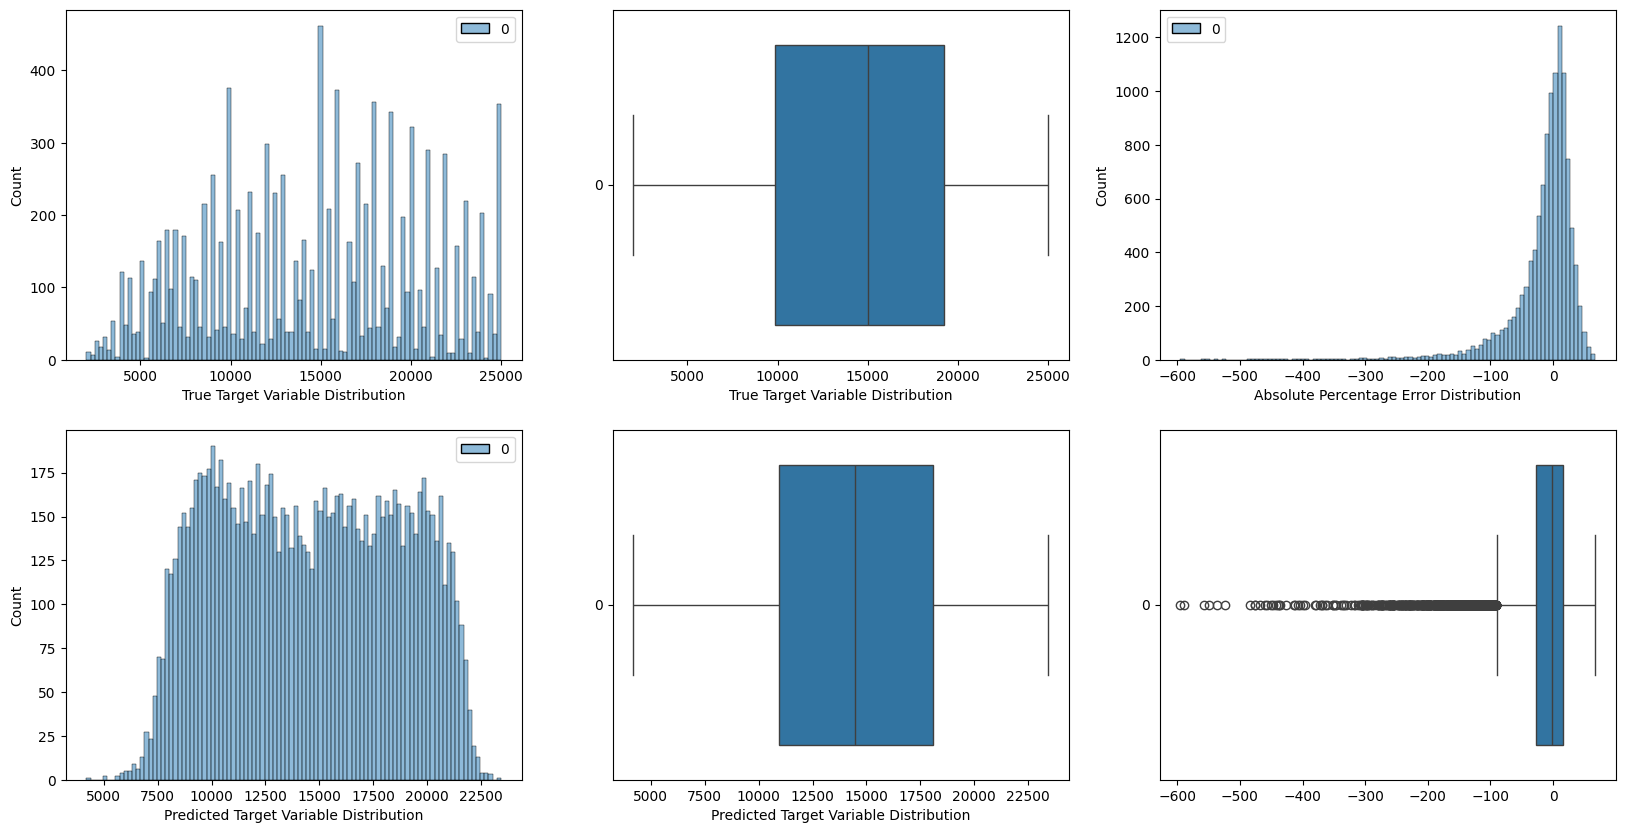

End Time: 2025-08-16 22:19:25.136803


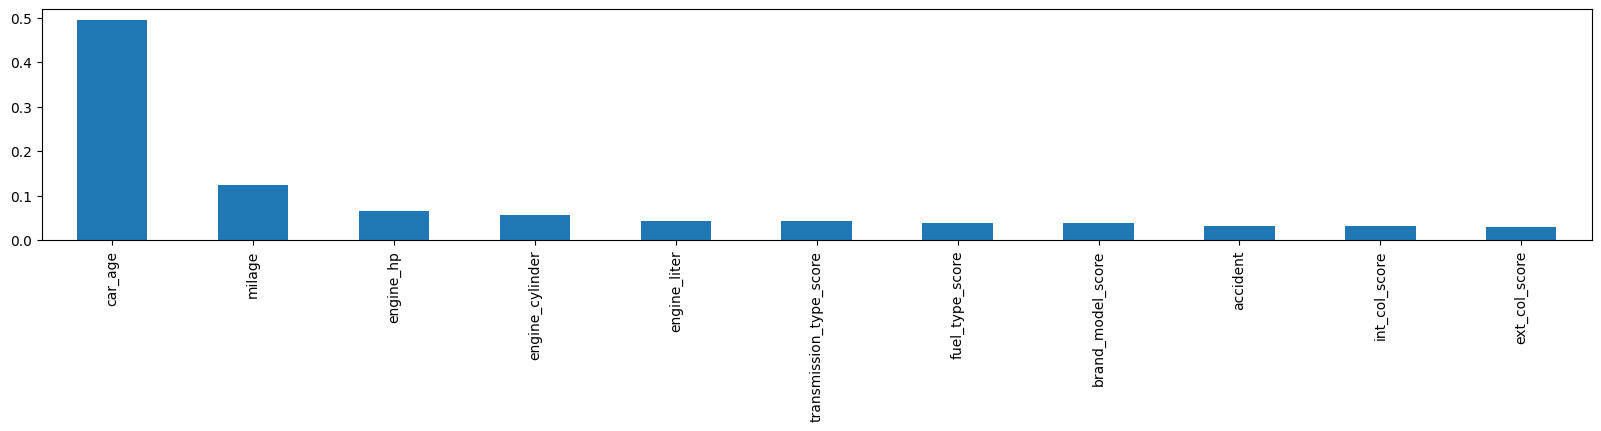

In [390]:
print("Start Time:", datetime.now())

X_test_scaled=ScalerFitX.transform(X_test)
y_test_scaled=ScalerFitY.transform(y_test.reshape(-1,1))

# Define Regression Model
Low_XGBR=XGBRegressor(tree_method='hist', booster='gbtree',random_state=42,
                  subsample=0.6,
                  n_estimators=400,
                  max_depth=6,
                  learning_rate=0.05
                 )

Low_XGBfit=Low_XGBR.fit(X_train_scaled,y_train_scaled)
y_pred_scaled=Low_XGBfit.predict(X_test_scaled)

# Inverse Transform ofy_pred
y_pred=ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1))

# Error metrics after Reverse Transformation to actual price with np.exp()
y_test=y_test.reshape(-1,1)
y_err=((y_test-y_pred)/y_test)*100
MAE=metrics.mean_absolute_error(y_test,y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_test,y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
MeAE=metrics.median_absolute_error(y_test,y_pred)
print("MAE = ",MAE, "MAPE = ",MAPE, "RMSE = ",RMSE, "Median Absolute Error:", MeAE)

# Plots
fig,subplt=plt.subplots(nrows=2,ncols=3,figsize=(20,10))
sns.histplot(data=y_test,bins=100,ax=subplt[0,0])
subplt[0,0].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_test,orient='h',ax=subplt[0,1])
subplt[0,1].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.histplot(data=y_pred,bins=100,ax=subplt[1,0])
subplt[1,0].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_pred,orient='h',ax=subplt[1,1])
subplt[1,1].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.histplot(data=y_err,bins=100,ax=subplt[0,2])
sns.boxplot(data=y_err,orient='h',ax=subplt[1,2])
subplt[0,2].set_xlabel('Absolute Percentage Error Distribution',fontsize=10)

plt.show()
plt.tight_layout()

pd.Series(data=Low_XGBfit.feature_importances_,index=LowRegPerdictors).sort_values(ascending=False).plot.bar(figsize=(20,3))

print("End Time:", datetime.now())

#### LightGBM with RandomizedSearchCV

In [391]:
print("Start Time:", datetime.now())

X=train_low[LowRegPerdictors]  # No to_numpy()
y=train_low[LowRegTarget].to_numpy()

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.15, random_state=42)

# Define Scaler
#scaler=StandardScaler()
ScalerFitX=StandardScaler().fit(X_train)
X_train_scaled=ScalerFitX.transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled,columns=LowRegPerdictors)
ScalerFitY=StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled=ScalerFitY.transform(y_train.reshape(-1,1))
print("Shapes of X_train and y_train:", X_train.shape, y_train.shape)
print("Shapes of X_train_scaled and y_train_scaled:", X_train_scaled.shape, y_train_scaled.shape)
#print(X_train_scaled.head(5))
#print(y_train_scaled)

# Define Cross Validation Model
cvm=KFold(n_splits=10,shuffle=True,random_state=42)

# Define Regression Model
Low_LGBM = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1)

# Define Pipe
#pipe=Pipeline(steps=[['scaler',scaler],['model',LGBM]])

param_dist = {
    'max_depth': [5, 7, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'n_estimators': [200, 300, 400, 500]
}


search = RandomizedSearchCV(
    estimator=Low_LGBM,
    param_distributions=param_dist,
    n_iter=50,  # 50 combinations, randomly chosen --> This parameter has to be smaller than the total parameter combination, 4x4x5x3=240, in this case
    scoring='neg_root_mean_squared_error',
    cv=cvm
)

search.fit(X_train_scaled, y_train_scaled.flatten())

print("Best Score:", search.best_score_)
print("\n")
print("Best Params:", search.best_params_)
print("\n")
print("Best Estimator:", search.best_estimator_)

print("End Time:", datetime.now())

Start Time: 2025-08-16 22:20:12.511472
Shapes of X_train and y_train: (63738, 11) (63738,)
Shapes of X_train_scaled and y_train_scaled: (63738, 11) (63738, 1)
Best Score: -0.7278960310099836


Best Params: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.08}


Best Estimator: LGBMRegressor(learning_rate=0.08, max_depth=15, n_estimators=300,
              objective='regression', random_state=42, subsample=0.6,
              verbose=-1)
End Time: 2025-08-16 22:26:30.288680


##### Re-creating LightGBM model with Best Parameters found above and testing the model on Test set

Start Time: 2025-08-23 22:14:29.849358

 Regression Model for price range segment 'low': 

LGBMRegressor(learning_rate=0.08, max_depth=15, n_estimators=300,
              objective='regression', random_state=42, subsample=0.6,
              verbose=-1)


MAE =  3365.327533217944 MAPE =  0.3243297088313909 RMSE =  4280.105222424713 Median Absolute Error: 2799.9134544493354




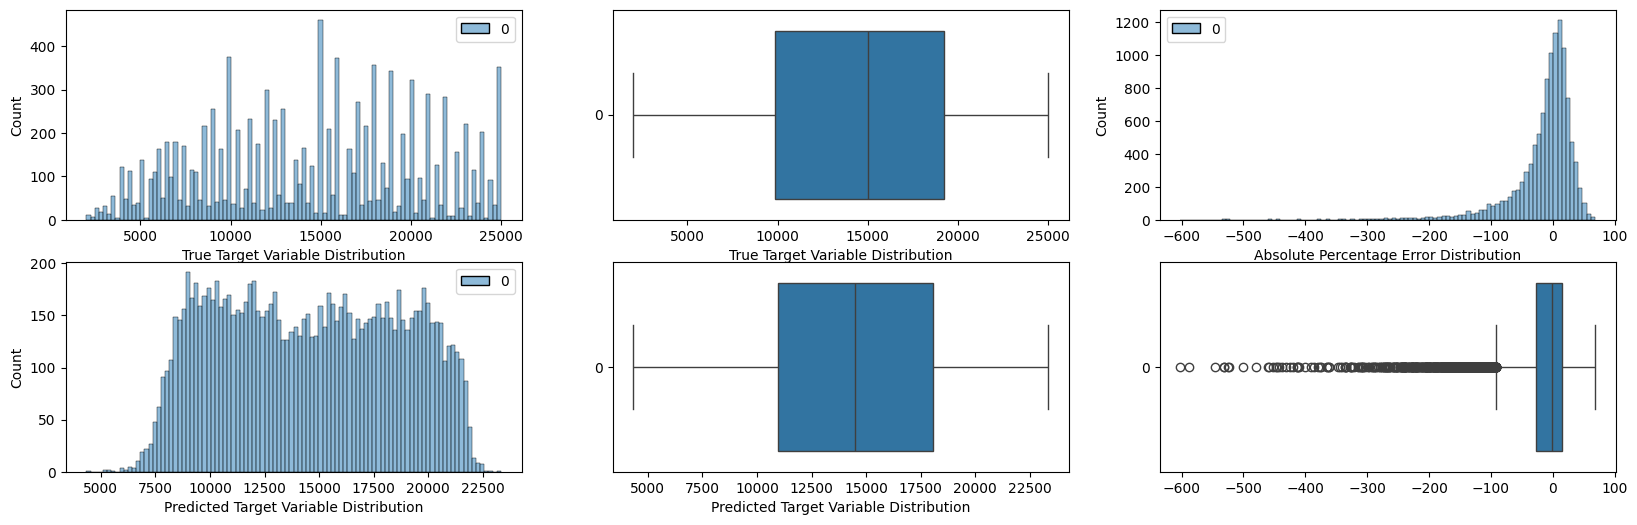

End Time: 2025-08-23 22:14:31.157076


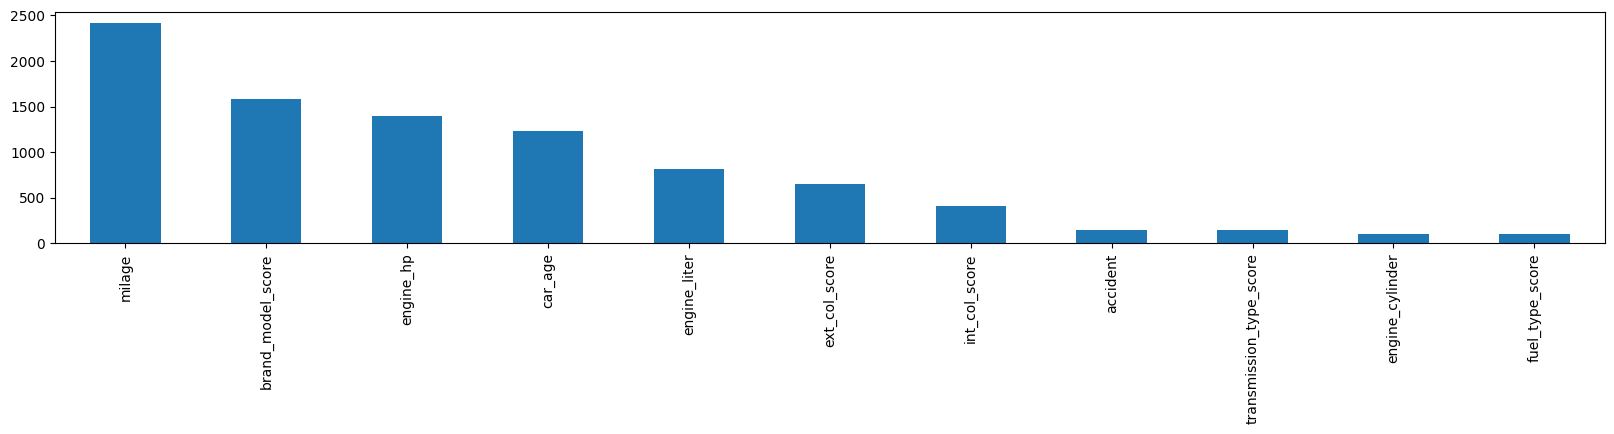

In [129]:
print("Start Time:", datetime.now())

X_test_scaled=ScalerFitX.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=LowRegPerdictors)
y_test_scaled=ScalerFitY.transform(y_test.reshape(-1,1))

# Define Regression Model
Low_LGBM = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1,
                         subsample=0.6, n_estimators=300, max_depth=15, learning_rate= 0.08)

Low_LGBMfit=Low_LGBM.fit(X_train_scaled,y_train_scaled.flatten())
print("\n Regression Model for price range segment 'low': \n")
print(Low_LGBMfit)
y_pred_scaled=Low_LGBMfit.predict(X_test_scaled)

# Inverse Transform ofy_pred
y_pred=ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1))

# Error metrics after Reverse Transformation to actual price with np.exp()
y_test=y_test.reshape(-1,1)
y_err=((y_test-y_pred)/y_test)*100
MAE=metrics.mean_absolute_error(y_test,y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_test,y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
MeAE=metrics.median_absolute_error(y_test,y_pred)
print("\n")
print("MAE = ",MAE, "MAPE = ",MAPE, "RMSE = ",RMSE, "Median Absolute Error:", MeAE)
print("\n")

# Plots
fig,subplt=plt.subplots(nrows=2,ncols=3,figsize=(20,6))
sns.histplot(data=y_test,bins=100,ax=subplt[0,0])
subplt[0,0].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_test,orient='h',ax=subplt[0,1])
subplt[0,1].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.histplot(data=y_pred,bins=100,ax=subplt[1,0])
subplt[1,0].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_pred,orient='h',ax=subplt[1,1])
subplt[1,1].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.histplot(data=y_err,bins=100,ax=subplt[0,2])
sns.boxplot(data=y_err,orient='h',ax=subplt[1,2])
subplt[0,2].set_xlabel('Absolute Percentage Error Distribution',fontsize=10)

plt.show()
plt.tight_layout()

pd.Series(data=Low_LGBMfit.feature_importances_,index=LowRegPerdictors).sort_values(ascending=False).plot.bar(figsize=(20,3))

print("End Time:", datetime.now())

##### Based on the above regression model metrics, I choose LightGBM Regressor for predicting used car prices of price range low.

In [126]:
print("Start Time:", datetime.now())

LowRegPerdictors=['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score']
LowRegTarget='price'

X=train_low[LowRegPerdictors]  # No to_numpy()
y=train_low[LowRegTarget].to_numpy()

LowScalerFitX=StandardScaler().fit(X)
X=LowScalerFitX.transform(X)
X=pd.DataFrame(X,columns=LowRegPerdictors)
LowScalerFitY=StandardScaler().fit(y.reshape(-1,1))
y=LowScalerFitY.transform(y.reshape(-1,1))

# Define Regression Model
FinalRegLow = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1,
                         subsample=0.6, n_estimators=300, max_depth=15, learning_rate= 0.08)

FinalRegLowFit=FinalRegLow.fit(X,y.flatten())

# Inverse Transform ofy_pred
#y_pred=ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1))

Start Time: 2025-08-24 11:34:19.617691


#### Regression Model for price_range mid, price value between 25,000 and 100,000

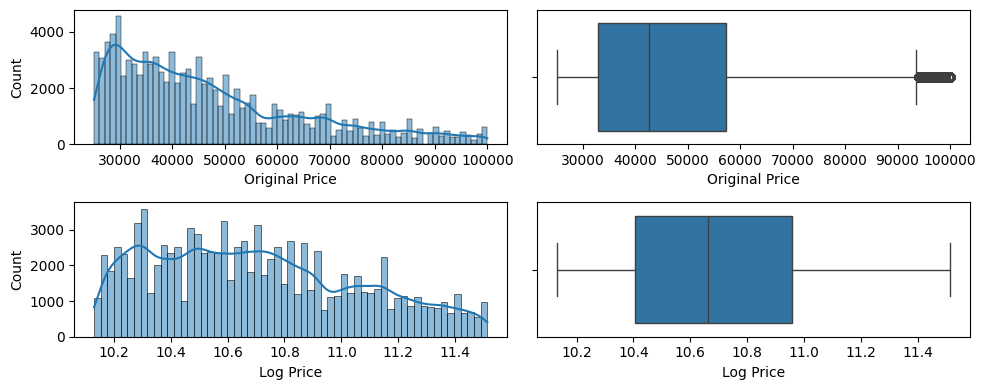

In [118]:
fig,subplt=plt.subplots(2,2,figsize=(10,4))
sns.histplot(data=train_mid['price'],kde=True,ax=subplt[0,0])
sns.histplot(data=np.log1p(train_mid['price']),kde=True,ax=subplt[1,0])
subplt[0,0].set_xlabel('Original Price')
subplt[1,0].set_xlabel('Log Price')
sns.boxplot(data=train_mid,x='price',orient='h',ax=subplt[0,1])
sns.boxplot(data=train_mid,x=np.log1p(train_mid['price']),orient='h',ax=subplt[1,1])
subplt[0,1].set_xlabel('Original Price')
subplt[1,1].set_xlabel('Log Price')
plt.tight_layout()

##### For this 'mid' price range (price between 25,000 and 100,000) the 'price' distribution is right skewed. Hence, I am taking log transformation of the 'price' to develop regression models.

In [128]:
train_mid['log_price']=train_mid['price'].apply(lambda x:np.log1p(x))
train_mid.shape

(103109, 14)

In [129]:
MidRegTarget='log_price'
MidRegPerdictors=train_mid.columns.drop(['price_range','price','log_price'])
print(MidRegPerdictors)

Index(['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score'],
      dtype='object')


#### XGBoost with RandomizedSearchCV

In [121]:
print("Start Time:", datetime.now())

X=train_mid[MidRegPerdictors].to_numpy()
y=train_mid[MidRegTarget].to_numpy()

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.15, random_state=42)

# Define Scaler
#scaler=StandardScaler()
ScalerFitX=StandardScaler().fit(X_train)
X_train_scaled=ScalerFitX.transform(X_train)
ScalerFitY=StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled=ScalerFitY.transform(y_train.reshape(-1,1))
print("Shapes of X_train and y_train:", X_train.shape, y_train.shape)
print("Shapes of X_train_scaled and y_train_scaled:", X_train_scaled.shape, y_train_scaled.shape)

# Define Cross Validation Model
cvm=KFold(n_splits=10,shuffle=True,random_state=42)

# Define Regression Model
Mid_XGBR=XGBRegressor(tree_method='hist', booster='gbtree',random_state=42)    ### tree_method='hist' is selected for making the algorithm run faster

# Define Pipe
#pipe=Pipeline(steps=[['scaler',scaler],['model',XGBR]])

#param_dist = {
#    'model__max_depth': [5, 6, 8, 10],
#    'model__learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
#    'model__subsample': [0.5, 0.6, 0.8, 1.0],
#    'model__n_estimators': [200, 300, 400, 500]
#}

param_dist = {
    'max_depth': [5, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'n_estimators': [200, 300, 400, 500]
}

search = RandomizedSearchCV(
    estimator=Mid_XGBR,
    param_distributions=param_dist,
    n_iter=50,  # 50 combinations, randomly chosen --> This parameter has to be smaller than the total parameter combination, 4x4x5x3=240, in this case
    scoring='neg_root_mean_squared_error',
    cv=cvm
)

search.fit(X_train_scaled, y_train_scaled)

print("Best Score:", search.best_score_)
print("\n")
print("Best Params:", search.best_params_)
print("\n")
print("Best Estimator:", search.best_estimator_)

print("End Time:", datetime.now())

Start Time: 2025-08-17 19:14:41.926793
Shapes of X_train and y_train: (87642, 11) (87642,)
Shapes of X_train_scaled and y_train_scaled: (87642, 11) (87642, 1)
Best Score: -0.780100229030556


Best Params: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05}


Best Estimator: XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
   

##### Re-creating XGBoost model with Best Parameters found above and testing the model on Test set

Start Time: 2025-08-17 19:46:48.107075
MAE =  10641.85917788174 MAPE =  0.22307265859629807 RMSE =  14489.54365341163 Median Absolute Error: 7562.093750000022


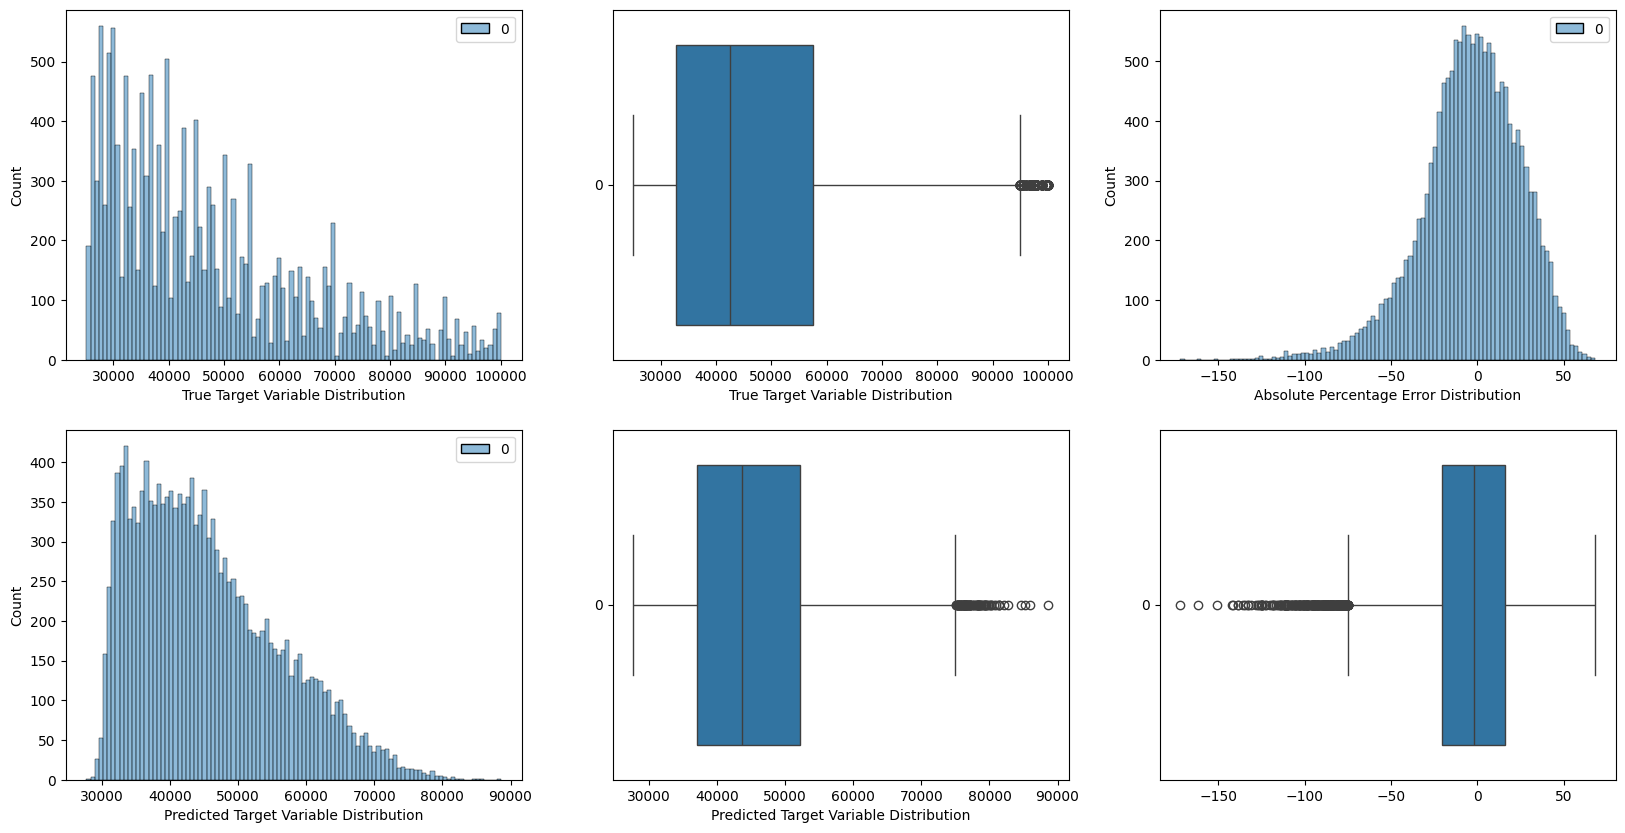

End Time: 2025-08-17 19:46:54.263888


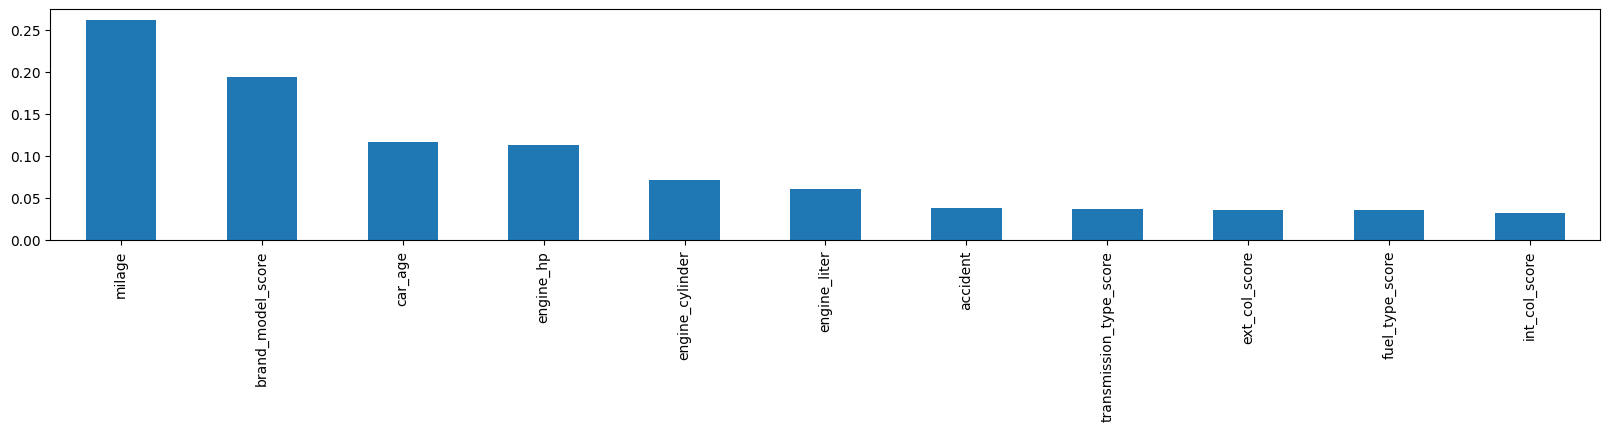

In [122]:
print("Start Time:", datetime.now())

X_test_scaled=ScalerFitX.transform(X_test)
y_test_scaled=ScalerFitY.transform(y_test.reshape(-1,1))

# Define Regression Model
Mid_XGBR=XGBRegressor(tree_method='hist', booster='gbtree',random_state=42,
                  subsample=0.8,
                  n_estimators=500,
                  max_depth=6,
                  learning_rate=0.05
                 )

Mid_XGBfit=Mid_XGBR.fit(X_train_scaled,y_train_scaled)
y_pred_scaled=Mid_XGBfit.predict(X_test_scaled)

# Inverse Transform of y_pred and y_test
y_pred=np.expm1(ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1)))
y_test=np.expm1(y_test)

# Error metrics after Reverse Transformation to actual price with np.exp()
y_test=y_test.reshape(-1,1)
y_err=((y_test-y_pred)/y_test)*100
MAE=metrics.mean_absolute_error(y_test,y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_test,y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
MeAE=metrics.median_absolute_error(y_test,y_pred)
print("MAE = ",MAE, "MAPE = ",MAPE, "RMSE = ",RMSE, "Median Absolute Error:", MeAE)

# Plots
fig,subplt=plt.subplots(nrows=2,ncols=3,figsize=(20,10))
sns.histplot(data=y_test,bins=100,ax=subplt[0,0])
subplt[0,0].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_test,orient='h',ax=subplt[0,1])
subplt[0,1].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.histplot(data=y_pred,bins=100,ax=subplt[1,0])
subplt[1,0].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_pred,orient='h',ax=subplt[1,1])
subplt[1,1].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.histplot(data=y_err,bins=100,ax=subplt[0,2])
sns.boxplot(data=y_err,orient='h',ax=subplt[1,2])
subplt[0,2].set_xlabel('Absolute Percentage Error Distribution',fontsize=10)

plt.show()
plt.tight_layout()

pd.Series(data=Mid_XGBfit.feature_importances_,index=LowRegPerdictors).sort_values(ascending=False).plot.bar(figsize=(20,3))

print("End Time:", datetime.now())

#### LightGBM with RandomizedSearchCV

In [123]:
print("Start Time:", datetime.now())

X=train_mid[MidRegPerdictors]  # No to_numpy()
y=train_mid[MidRegTarget].to_numpy()

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.15, random_state=42)

# Define Scaler
#scaler=StandardScaler()
ScalerFitX=StandardScaler().fit(X_train)
X_train_scaled=ScalerFitX.transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled,columns=MidRegPerdictors)
ScalerFitY=StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled=ScalerFitY.transform(y_train.reshape(-1,1))
print("Shapes of X_train and y_train:", X_train.shape, y_train.shape)
print("Shapes of X_train_scaled and y_train_scaled:", X_train_scaled.shape, y_train_scaled.shape)
#print(X_train_scaled.head(5))
#print(y_train_scaled)

# Define Cross Validation Model
cvm=KFold(n_splits=10,shuffle=True,random_state=42)

# Define Regression Model
LGBM = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1)

# Define Pipe
#pipe=Pipeline(steps=[['scaler',scaler],['model',LGBM]])

param_dist = {
    'max_depth': [5, 7, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'n_estimators': [200, 300, 400, 500]
}


search = RandomizedSearchCV(
    estimator=LGBM,
    param_distributions=param_dist,
    n_iter=50,  # 50 combinations, randomly chosen --> This parameter has to be smaller than the total parameter combination, 4x4x5x3=240, in this case
    scoring='neg_root_mean_squared_error',
    cv=cvm
)

search.fit(X_train_scaled, y_train_scaled.flatten())

print("Best Score:", search.best_score_)
print("\n")
print("Best Params:", search.best_params_)
print("\n")
print("Best Estimator:", search.best_estimator_)

print("End Time:", datetime.now())

Start Time: 2025-08-17 19:53:30.394980
Shapes of X_train and y_train: (87642, 11) (87642,)
Shapes of X_train_scaled and y_train_scaled: (87642, 11) (87642, 1)
Best Score: -0.7806725463003814


Best Params: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.08}


Best Estimator: LGBMRegressor(learning_rate=0.08, max_depth=5, n_estimators=500,
              objective='regression', random_state=42, subsample=0.8,
              verbose=-1)
End Time: 2025-08-17 20:02:24.103639


##### Re-creating LightGBM model with Best Parameters found above and testing the model on Test set

Start Time: 2025-08-23 22:25:45.760465

 Regression Model for price range segment 'mid': 

LGBMRegressor(learning_rate=0.08, max_depth=5, n_estimators=500,
              objective='regression', random_state=42, subsample=0.8,
              verbose=-1)


MAE =  10636.565840503143 MAPE =  0.2230357761160327 RMSE =  14491.906018628632 Median Absolute Error: 7544.8675983667235


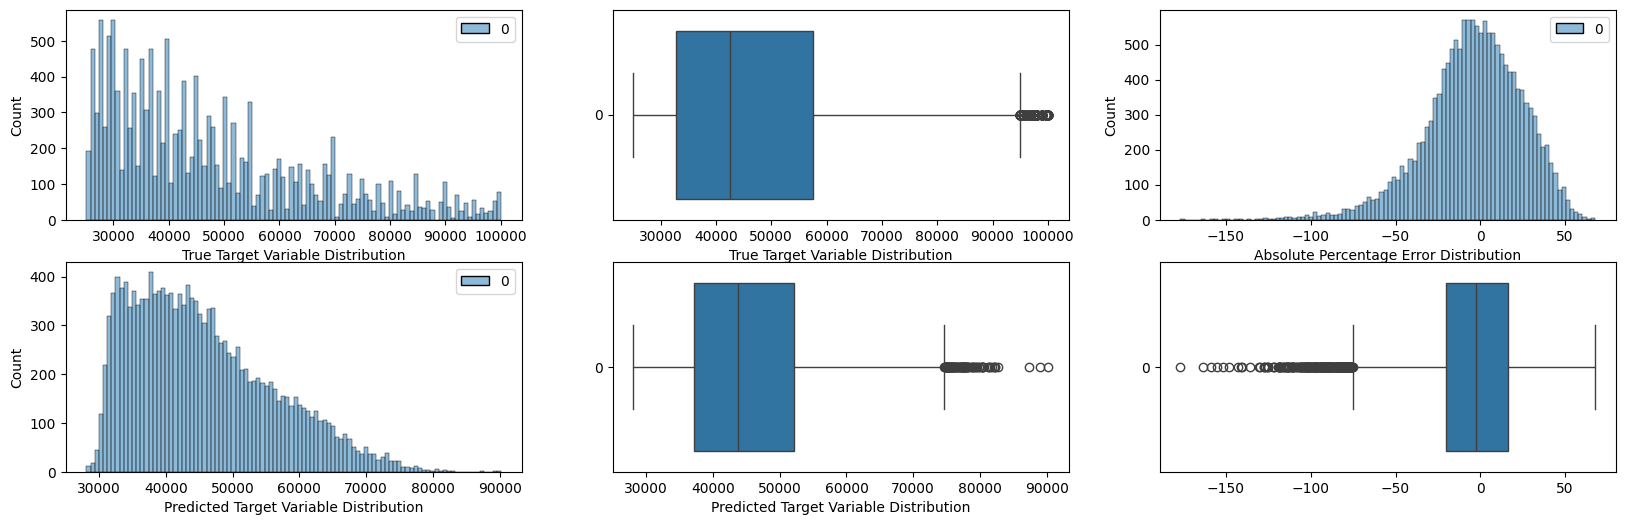

End Time: 2025-08-23 22:25:47.561998


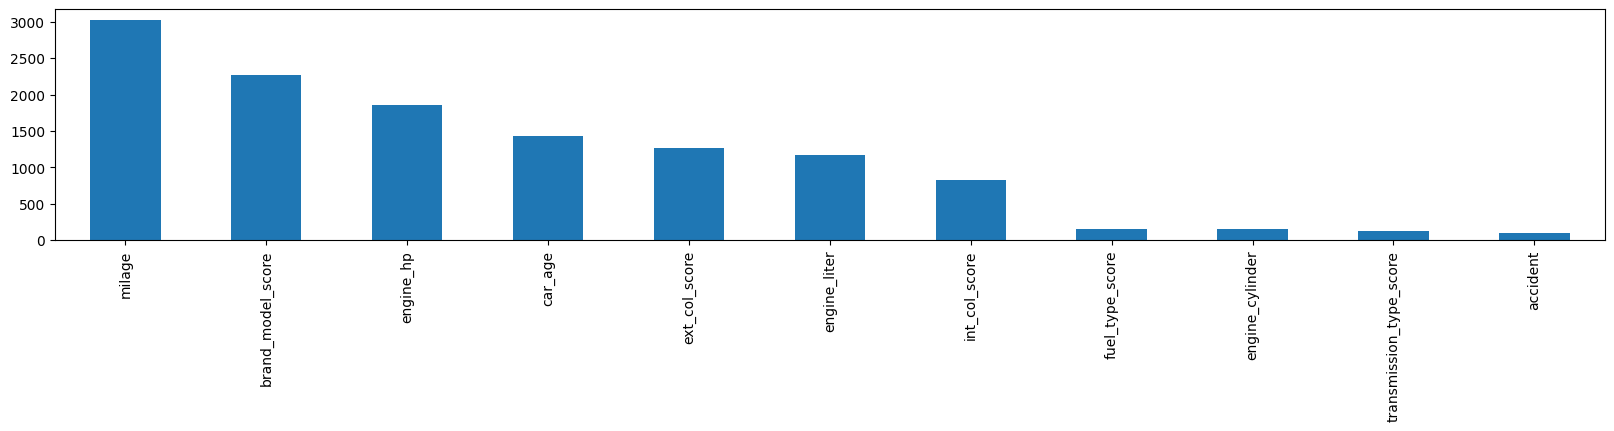

In [143]:
print("Start Time:", datetime.now())

X_test_scaled=ScalerFitX.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=LowRegPerdictors)
y_test_scaled=ScalerFitY.transform(y_test.reshape(-1,1))

# Define Regression Model
Mid_LGBM = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1,
                         subsample=0.8, n_estimators=500, max_depth=5, learning_rate= 0.08)

Mid_LGBMfit=Mid_LGBM.fit(X_train_scaled,y_train_scaled.flatten())
print("\n Regression Model for price range segment 'mid': \n")
print(Mid_LGBMfit)
print("\n")
y_pred_scaled=Mid_LGBMfit.predict(X_test_scaled)

# Inverse Transform of y_pred and y_test
y_pred=np.expm1(ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1)))
y_test=np.expm1(y_test)

# Error metrics after Reverse Transformation to actual price with np.exp()
y_test=y_test.reshape(-1,1)
y_err=((y_test-y_pred)/y_test)*100
MAE=metrics.mean_absolute_error(y_test,y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_test,y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
MeAE=metrics.median_absolute_error(y_test,y_pred)
print("MAE = ",MAE, "MAPE = ",MAPE, "RMSE = ",RMSE, "Median Absolute Error:", MeAE)

# Plots
fig,subplt=plt.subplots(nrows=2,ncols=3,figsize=(20,6))
sns.histplot(data=y_test,bins=100,ax=subplt[0,0])
subplt[0,0].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_test,orient='h',ax=subplt[0,1])
subplt[0,1].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.histplot(data=y_pred,bins=100,ax=subplt[1,0])
subplt[1,0].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_pred,orient='h',ax=subplt[1,1])
subplt[1,1].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.histplot(data=y_err,bins=100,ax=subplt[0,2])
sns.boxplot(data=y_err,orient='h',ax=subplt[1,2])
subplt[0,2].set_xlabel('Absolute Percentage Error Distribution',fontsize=10)

plt.show()
plt.tight_layout()

pd.Series(data=Mid_LGBMfit.feature_importances_,index=LowRegPerdictors).sort_values(ascending=False).plot.bar(figsize=(20,3))

print("End Time:", datetime.now())

##### Based on the regression model metrics above, I choose LightGBM Regressor model for predicting price of used cars in price range 'mid'.

In [131]:
print("Start Time:", datetime.now())

MidRegPerdictors=['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score']
MidRegTarget='log_price'

X=train_mid[MidRegPerdictors]  # No to_numpy()
y=train_mid[MidRegTarget].to_numpy()

MidScalerFitX=StandardScaler().fit(X)
X=MidScalerFitX.transform(X)
X=pd.DataFrame(X,columns=LowRegPerdictors)
MidScalerFitY=StandardScaler().fit(y.reshape(-1,1))
y=MidScalerFitY.transform(y.reshape(-1,1))

# Define Regression Model
FinalRegMid = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1,
                         subsample=0.8, n_estimators=500, max_depth=5, learning_rate= 0.08)

FinalRegMidFit=FinalRegMid.fit(X,y.flatten())

# Inverse Transform ofy_pred
#y_pred=ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1))

Start Time: 2025-08-24 11:35:37.195060


#### Regression Model for price_range high, price value above 100,000

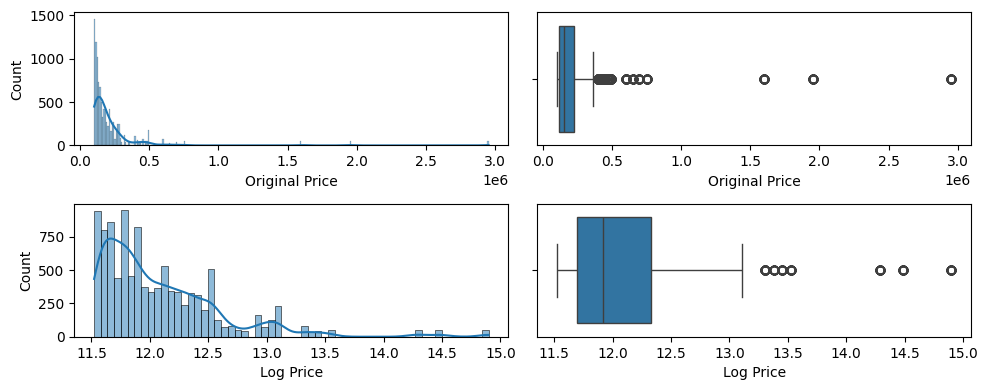

In [126]:
fig,subplt=plt.subplots(2,2,figsize=(10,4))
sns.histplot(data=train_high['price'],kde=True,ax=subplt[0,0])
sns.histplot(data=np.log1p(train_high['price']),kde=True,ax=subplt[1,0])
subplt[0,0].set_xlabel('Original Price')
subplt[1,0].set_xlabel('Log Price')
sns.boxplot(data=train_high,x='price',orient='h',ax=subplt[0,1])
sns.boxplot(data=train_high,x=np.log1p(train_high['price']),orient='h',ax=subplt[1,1])
subplt[0,1].set_xlabel('Original Price')
subplt[1,1].set_xlabel('Log Price')
plt.tight_layout()

##### For this 'mid' price range (price between 25,000 and 100,000) the 'price' distribution is right skewed. Hence, I am taking log transformation of the 'price' to develop regression models.

In [132]:
train_high['log_price']=train_high['price'].apply(lambda x:np.log1p(x))
train_high.shape

(10437, 14)

In [133]:
HighRegTarget='log_price'
HighRegPerdictors=train_mid.columns.drop(['price_range','price','log_price'])
print(HighRegPerdictors)

Index(['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score'],
      dtype='object')


#### XGBoost with RandomizedSearchCV

In [129]:
print("Start Time:", datetime.now())

X=train_high[HighRegPerdictors].to_numpy()
y=train_high[HighRegTarget].to_numpy()

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.15, random_state=42)

# Define Scaler
#scaler=StandardScaler()
ScalerFitX=StandardScaler().fit(X_train)
X_train_scaled=ScalerFitX.transform(X_train)
ScalerFitY=StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled=ScalerFitY.transform(y_train.reshape(-1,1))
print("Shapes of X_train and y_train:", X_train.shape, y_train.shape)
print("Shapes of X_train_scaled and y_train_scaled:", X_train_scaled.shape, y_train_scaled.shape)

# Define Cross Validation Model
cvm=KFold(n_splits=10,shuffle=True,random_state=42)

# Define Regression Model
High_XGBR=XGBRegressor(tree_method='hist', booster='gbtree',random_state=42)    ### tree_method='hist' is selected for making the algorithm run faster

# Define Pipe
#pipe=Pipeline(steps=[['scaler',scaler],['model',XGBR]])

#param_dist = {
#    'model__max_depth': [5, 6, 8, 10],
#    'model__learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
#    'model__subsample': [0.5, 0.6, 0.8, 1.0],
#    'model__n_estimators': [200, 300, 400, 500]
#}

param_dist = {
    'max_depth': [5, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'n_estimators': [200, 300, 400, 500]
}

search = RandomizedSearchCV(
    estimator=High_XGBR,
    param_distributions=param_dist,
    n_iter=50,  # 50 combinations, randomly chosen --> This parameter has to be smaller than the total parameter combination, 4x4x5x3=240, in this case
    scoring='neg_root_mean_squared_error',
    cv=cvm
)

search.fit(X_train_scaled, y_train_scaled)

print("Best Score:", search.best_score_)
print("\n")
print("Best Params:", search.best_params_)
print("\n")
print("Best Estimator:", search.best_estimator_)

print("End Time:", datetime.now())

Start Time: 2025-08-17 20:09:31.162697
Shapes of X_train and y_train: (8871, 11) (8871,)
Shapes of X_train_scaled and y_train_scaled: (8871, 11) (8871, 1)
Best Score: -0.9670300773238516


Best Params: {'subsample': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01}


Best Estimator: XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
      

##### Re-creating XGBoost model with Best Parameters found above and testing the model on Test set

Start Time: 2025-08-17 20:19:23.727073
MAE =  89508.5642161558 MAPE =  0.3549943497152834 RMSE =  216188.9785885958 Median Absolute Error: 49743.08593749997


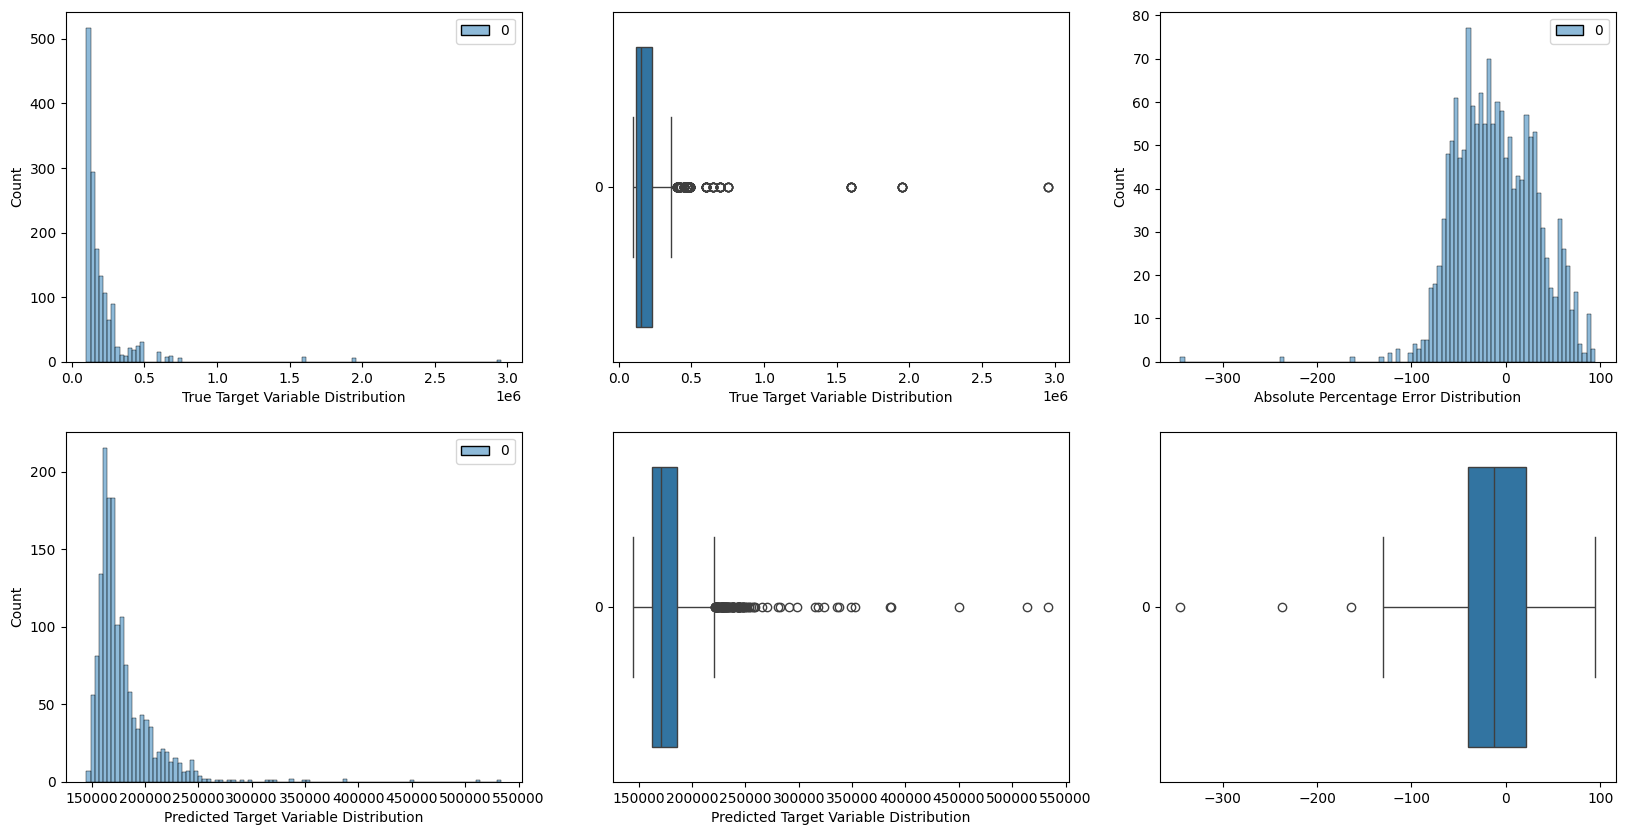

End Time: 2025-08-17 20:19:25.203809


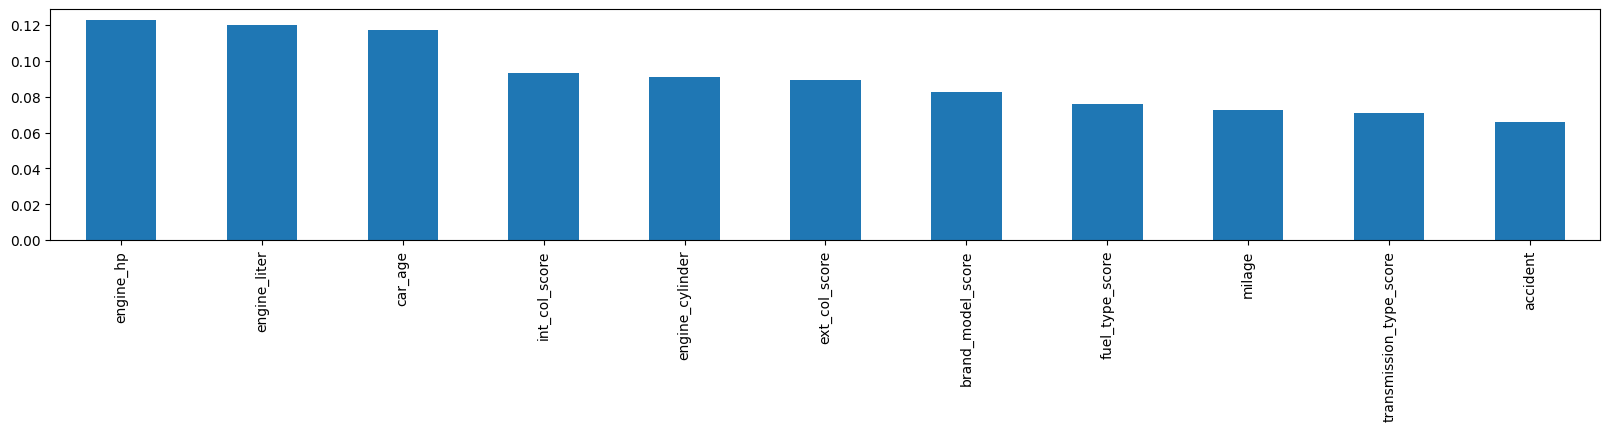

In [130]:
print("Start Time:", datetime.now())

X_test_scaled=ScalerFitX.transform(X_test)
y_test_scaled=ScalerFitY.transform(y_test.reshape(-1,1))

# Define Regression Model
High_XGBR=XGBRegressor(tree_method='hist', booster='gbtree',random_state=42,
                  subsample=0.5,
                  n_estimators=300,
                  max_depth=5,
                  learning_rate=0.01
                 )

High_XGBfit=High_XGBR.fit(X_train_scaled,y_train_scaled)
y_pred_scaled=High_XGBfit.predict(X_test_scaled)

# Inverse Transform of y_pred and y_test
y_pred=np.expm1(ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1)))
y_test=np.expm1(y_test)

# Error metrics after Reverse Transformation to actual price with np.exp()
y_test=y_test.reshape(-1,1)
y_err=((y_test-y_pred)/y_test)*100
MAE=metrics.mean_absolute_error(y_test,y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_test,y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
MeAE=metrics.median_absolute_error(y_test,y_pred)
print("MAE = ",MAE, "MAPE = ",MAPE, "RMSE = ",RMSE, "Median Absolute Error:", MeAE)

# Plots
fig,subplt=plt.subplots(nrows=2,ncols=3,figsize=(20,10))
sns.histplot(data=y_test,bins=100,ax=subplt[0,0])
subplt[0,0].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_test,orient='h',ax=subplt[0,1])
subplt[0,1].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.histplot(data=y_pred,bins=100,ax=subplt[1,0])
subplt[1,0].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_pred,orient='h',ax=subplt[1,1])
subplt[1,1].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.histplot(data=y_err,bins=100,ax=subplt[0,2])
sns.boxplot(data=y_err,orient='h',ax=subplt[1,2])
subplt[0,2].set_xlabel('Absolute Percentage Error Distribution',fontsize=10)

plt.show()
plt.tight_layout()

pd.Series(data=High_XGBfit.feature_importances_,index=LowRegPerdictors).sort_values(ascending=False).plot.bar(figsize=(20,3))

print("End Time:", datetime.now())

#### LightGBM with RandomizedSearchCV

In [131]:
print("Start Time:", datetime.now())

X=train_high[HighRegPerdictors]  # No to_numpy()
y=train_high[HighRegTarget].to_numpy()

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.15, random_state=42)

# Define Scaler
#scaler=StandardScaler()
ScalerFitX=StandardScaler().fit(X_train)
X_train_scaled=ScalerFitX.transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled,columns=HighRegPerdictors)
ScalerFitY=StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled=ScalerFitY.transform(y_train.reshape(-1,1))
print("Shapes of X_train and y_train:", X_train.shape, y_train.shape)
print("Shapes of X_train_scaled and y_train_scaled:", X_train_scaled.shape, y_train_scaled.shape)
#print(X_train_scaled.head(5))
#print(y_train_scaled)

# Define Cross Validation Model
cvm=KFold(n_splits=10,shuffle=True,random_state=42)

# Define Regression Model
High_LGBM = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1)

# Define Pipe
#pipe=Pipeline(steps=[['scaler',scaler],['model',LGBM]])

param_dist = {
    'max_depth': [5, 7, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'n_estimators': [200, 300, 400, 500]
}


search = RandomizedSearchCV(
    estimator=High_LGBM,
    param_distributions=param_dist,
    n_iter=50,  # 50 combinations, randomly chosen --> This parameter has to be smaller than the total parameter combination, 4x4x5x3=240, in this case
    scoring='neg_root_mean_squared_error',
    cv=cvm
)

search.fit(X_train_scaled, y_train_scaled.flatten())

print("Best Score:", search.best_score_)
print("\n")
print("Best Params:", search.best_params_)
print("\n")
print("Best Estimator:", search.best_estimator_)

print("End Time:", datetime.now())

Start Time: 2025-08-17 20:20:01.250299
Shapes of X_train and y_train: (8871, 11) (8871,)
Shapes of X_train_scaled and y_train_scaled: (8871, 11) (8871, 1)
Best Score: -0.9698089622297628


Best Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.03}


Best Estimator: LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=200,
              objective='regression', random_state=42, verbose=-1)
End Time: 2025-08-17 20:22:01.917843


##### Re-creating LightGBM model with Best Parameters found above and testing the model on Test set

Start Time: 2025-08-17 20:27:34.407692
MAE =  89712.97190749136 MAPE =  0.3565897730624328 RMSE =  216051.5552915978 Median Absolute Error: 49029.89704698636


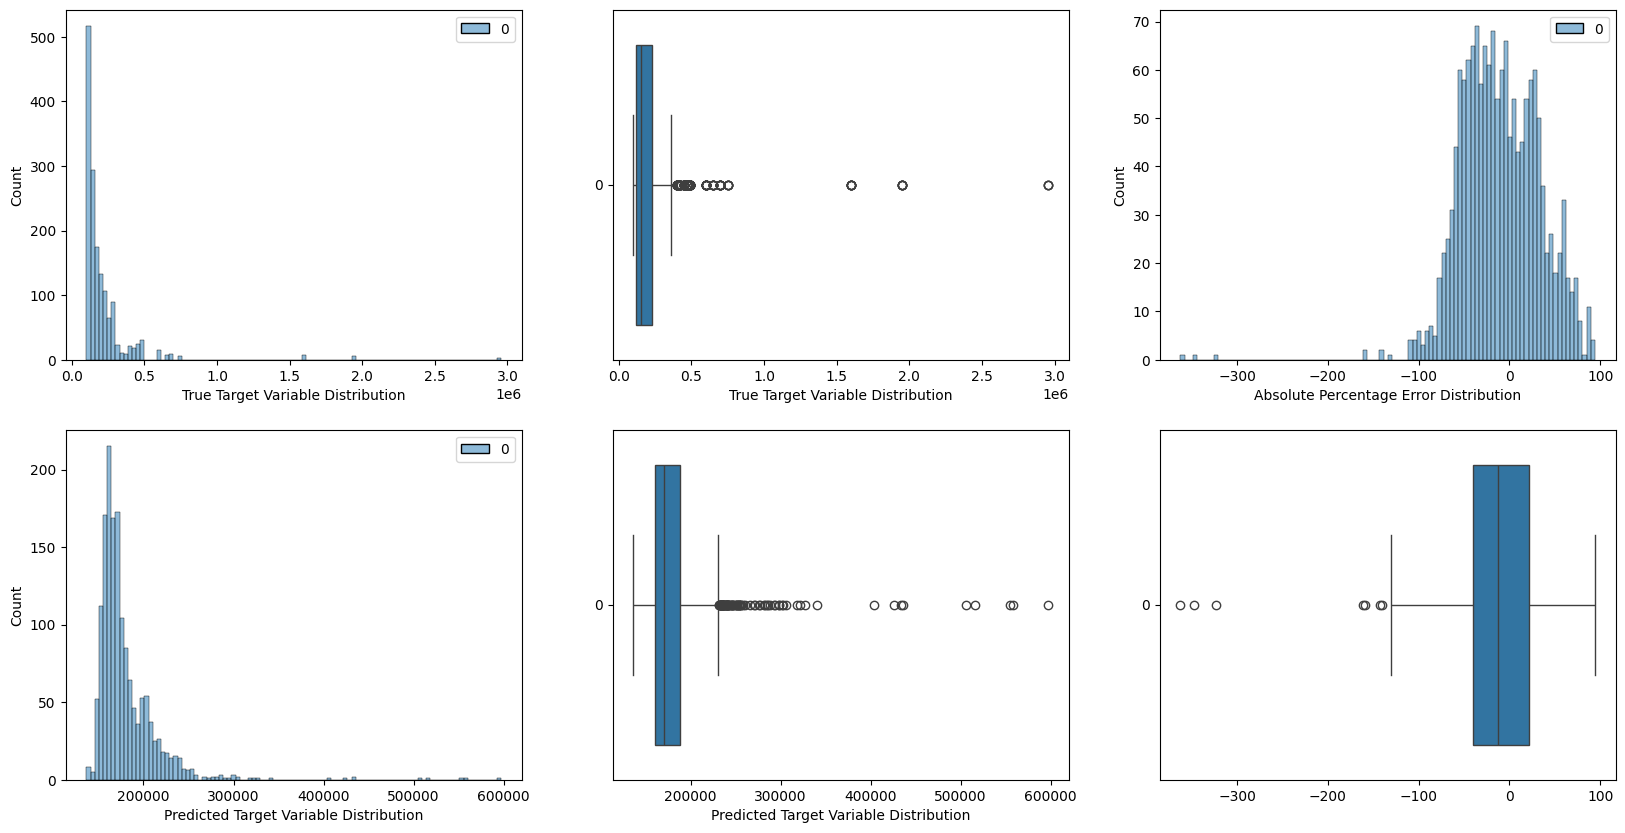

End Time: 2025-08-17 20:27:36.111751


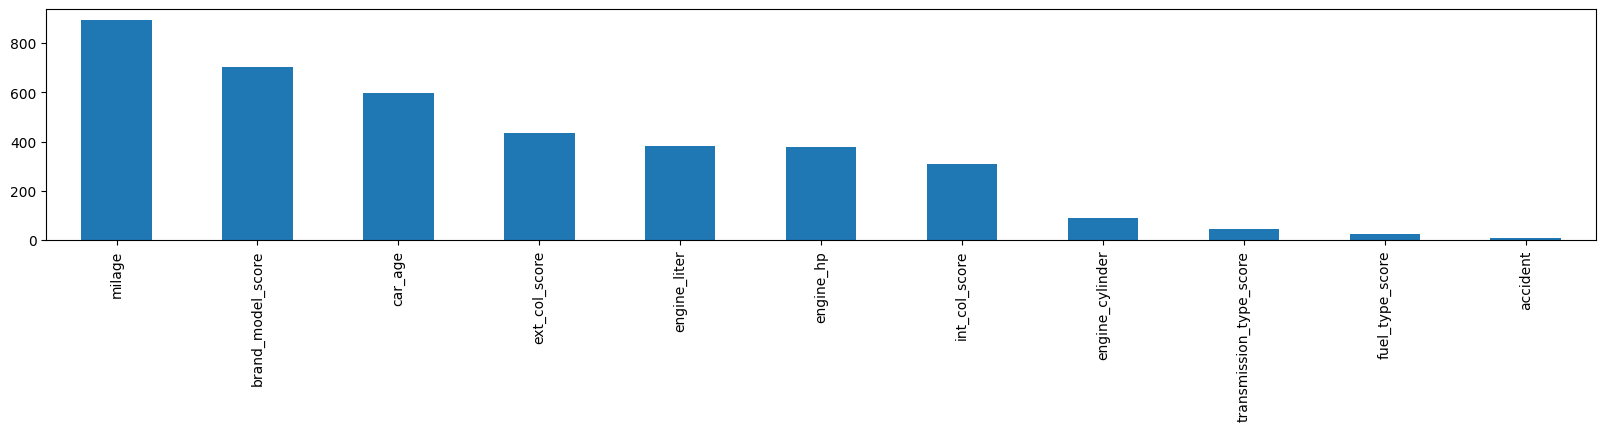

In [132]:
print("Start Time:", datetime.now())

X_test_scaled=ScalerFitX.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=HighRegPerdictors)
y_test_scaled=ScalerFitY.transform(y_test.reshape(-1,1))

# Define Regression Model
High_LGBM = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1,
                         subsample=1.0, n_estimators=200, max_depth=5, learning_rate= 0.03)

High_LGBMfit=High_LGBM.fit(X_train_scaled,y_train_scaled.flatten())
y_pred_scaled=High_LGBMfit.predict(X_test_scaled)

# Inverse Transform of y_pred and y_test
y_pred=np.expm1(ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1)))
y_test=np.expm1(y_test)

# Error metrics after Reverse Transformation to actual price with np.exp()
y_test=y_test.reshape(-1,1)
y_err=((y_test-y_pred)/y_test)*100
MAE=metrics.mean_absolute_error(y_test,y_pred)
MAPE=metrics.mean_absolute_percentage_error(y_test,y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
MeAE=metrics.median_absolute_error(y_test,y_pred)
print("MAE = ",MAE, "MAPE = ",MAPE, "RMSE = ",RMSE, "Median Absolute Error:", MeAE)

# Plots
fig,subplt=plt.subplots(nrows=2,ncols=3,figsize=(20,10))
sns.histplot(data=y_test,bins=100,ax=subplt[0,0])
subplt[0,0].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_test,orient='h',ax=subplt[0,1])
subplt[0,1].set_xlabel('True Target Variable Distribution',fontsize=10)
sns.histplot(data=y_pred,bins=100,ax=subplt[1,0])
subplt[1,0].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.boxplot(data=y_pred,orient='h',ax=subplt[1,1])
subplt[1,1].set_xlabel('Predicted Target Variable Distribution',fontsize=10)
sns.histplot(data=y_err,bins=100,ax=subplt[0,2])
sns.boxplot(data=y_err,orient='h',ax=subplt[1,2])
subplt[0,2].set_xlabel('Absolute Percentage Error Distribution',fontsize=10)

plt.show()
plt.tight_layout()

pd.Series(data=High_LGBMfit.feature_importances_,index=LowRegPerdictors).sort_values(ascending=False).plot.bar(figsize=(20,3))

print("End Time:", datetime.now())

##### Based on the above regression model metrics, I choose LightGBM Regressor model for predicting used car prices in price group high.

In [135]:
print("Start Time:", datetime.now())

HighRegPerdictors=['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score']
HighRegTarget='log_price'

X=train_high[HighRegPerdictors]  # No to_numpy()
y=train_high[HighRegTarget].to_numpy()

HighScalerFitX=StandardScaler().fit(X)
X=HighScalerFitX.transform(X)
X=pd.DataFrame(X,columns=LowRegPerdictors)
HighScalerFitY=StandardScaler().fit(y.reshape(-1,1))
y=HighScalerFitY.transform(y.reshape(-1,1))

# Define Regression Model
FinalRegHigh = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',random_state=42,verbose=-1,
                         subsample=1.0, n_estimators=200, max_depth=5, learning_rate= 0.03)

FinalRegHighFit=FinalRegHigh.fit(X,y.flatten())

# Inverse Transform ofy_pred
#y_pred=ScalerFitY.inverse_transform(y_pred_scaled.reshape(-1,1))

Start Time: 2025-08-24 11:36:14.185182


# Predicting the values:

#### Preparing Functions for replicating steps on Test Data

In [240]:
test_df_original=pd.read_csv(path+"test.csv",encoding='latin')
test_df=test_df_original.copy()
print("Test dataset shape:",test_df.shape)

Test dataset shape: (125690, 12)


In [241]:
# Setting 'id' as index
test_df.set_index(['id'],inplace=True,drop=True)
# Replace junk characters in any column as np.nan
test_df.replace({'â':np.nan},inplace=True)
# Joining 'brand' and 'model' in a single column as 'brand_model'
test_df['brand_model']=test_df['brand'].astype(str) + '-' + test_df['model'].astype(str)
# Adding 'car_age'
test_df['car_age']=2024-test_df['model_year']

test_df.shape

(125690, 13)

In [242]:
def missing_value_fillup(df):
    df=df.copy()
    
    df['fuel_type']=df['fuel_type'].fillna(df['brand_model'].map(fuel_type_map1))
    df['fuel_type']=df['fuel_type'].fillna(fuel_type_map2)

    df['engine_hp']=df['engine_hp'].fillna(df[['brand_model','fuel_type']].apply(tuple,axis=1).map(engine_hp_map1))
    df['engine_hp']=df['engine_hp'].fillna(df['brand_model'].map(engine_hp_map2))
    df['engine_hp']=df['engine_hp'].fillna(engine_hp_map3)

    df['engine_liter']=df['engine_liter'].fillna(df[['brand_model','fuel_type']].apply(tuple,axis=1).map(engine_liter_map1))
    df['engine_liter']=df['engine_liter'].fillna(df['brand_model'].map(engine_liter_map2))
    df['engine_liter']=df['engine_liter'].fillna(engine_liter_map3)

    df['engine_cylinder']=df['engine_cylinder'].fillna(df[['brand_model','fuel_type']].apply(tuple,axis=1).map(engine_cylinder_map1))
    df['engine_cylinder']=df['engine_cylinder'].fillna(df['brand_model'].map(engine_cylinder_map2))
    df['engine_cylinder']=df['engine_cylinder'].fillna(engine_cylinder_map3)

    df['transmission_type']=df['transmission_type'].fillna(df['brand_model'].map(transmission_type_map1))
    df['transmission_type']=df['transmission_type'].fillna(transmission_type_map2)

    df['ext_col']=df['ext_col'].fillna(df['brand_model'].map(ext_col_map1))
    df['ext_col']=df['ext_col'].fillna(ext_col_map2)

    df['int_col']=df['int_col'].fillna(df['brand_model'].map(int_col_map1))
    df['int_col']=df['int_col'].fillna(int_col_map2)

    return df

missing_value_fixer=FunctionTransformer(func=missing_value_fillup,validate=False)



def Cardinal_encoding(df):
    df=df.copy()

    df['brand_model_score']=df['brand_model'].map(brand_model_score_map)
    df['ext_col_score']=df['ext_col'].map(ext_col_score_map)
    df['int_col_score']=df['int_col'].map(int_col_score_map)
    df['fuel_type_score']=df['fuel_type'].map(fuel_type_score_map)
    df['transmission_type_score']=df['transmission_type'].map(transmission_type_score_map)

    df['brand_model_score']=df['brand_model_score'].fillna(train_global_median)
    df['ext_col_score']=df['ext_col_score'].fillna(train_global_median)
    df['int_col_score']=df['int_col_score'].fillna(train_global_median)
    df['fuel_type_score']=df['fuel_type_score'].fillna(train_global_median)
    df['transmission_type_score']=df['transmission_type_score'].fillna(train_global_median)
    
    return df


cardinal_encoding_fixer=FunctionTransformer(func=Cardinal_encoding,validate=False)

In [243]:
PreprocessorSteps1=[['fuel_type_fixer',fuel_type_fixer]
        ,['engine_hp_fixer',engine_hp_fixer]
		,['engine_liter_fixer',engine_liter_fixer]
		,['engine_cylinder_fixer',engine_cylinder_fixer]
		,['transmission_type_fixer', transmission_type_fixer]
        ,['missing_value_fixer', missing_value_fixer]
        ,['cardinal_encoding_fixer', cardinal_encoding_fixer]
        ,['accident_fixer',accident_fixer]
                   ]


In [244]:
pipe=Pipeline(steps=PreprocessorSteps1)

In [245]:
test_df=pipe.fit_transform(test_df)
selected_columns=['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter', 'engine_cylinder', 'brand_model_score', 
                  'ext_col_score', 'int_col_score', 'fuel_type_score', 'transmission_type_score']
test_df=test_df[selected_columns]
test_df.shape

(125690, 11)

In [246]:
test_df.isnull().sum()

milage                     0
accident                   0
car_age                    0
engine_hp                  0
engine_liter               0
engine_cylinder            0
brand_model_score          0
ext_col_score              0
int_col_score              0
fuel_type_score            0
transmission_type_score    0
dtype: int64

##### Predicting the 'price_range' value for each record of the unseen dataset

In [247]:
X_test=test_df.to_numpy()
X_test=ClassScalerFit.transform(X_test)
test_df['price_range']=FinalClassModelFit.predict(X_test)
test_df.shape

(125690, 12)

In [248]:
test_df.price_range.value_counts().sort_index()

price_range
0    45349
1    78790
2     1551
Name: count, dtype: int64

##### Predicting 'price' values for data records in the test dataset for each 'price_ragne' groups

##### Predicting price for 'price_range' group low (0)

In [249]:
LowRegPerdictors=['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score']

X_low=test_df[test_df['price_range']==0][LowRegPerdictors]  # No to_numpy()

X_low=LowScalerFitX.transform(X_low)
X_low=pd.DataFrame(X_low,columns=LowRegPerdictors)

y_low_pred=FinalRegLowFit.predict(X_low)
y_low_pred=LowScalerFitY.inverse_transform(y_low_pred.reshape(-1,1))
test_df.loc[test_df['price_range']==0, 'price']=y_low_pred.flatten()


In [250]:
test_df[test_df['price_range']==0].head(5)

,milage,accident,car_age,engine_hp,engine_liter,engine_cylinder,brand_model_score,ext_col_score,int_col_score,fuel_type_score,transmission_type_score,price_range,price
id,,,,,,,,,,,,,
188533,98000,1,9,240.00,2.00,4.00,9.91,10.29,9.89,10.31,10.37,0,17070.44
188536,61258,1,8,252.00,2.00,4.00,10.26,10.56,10.40,10.31,10.37,0,20733.09
188538,99524,1,11,285.00,4.80,8.00,10.03,10.31,10.40,10.31,10.37,0,17324.24
188539,194000,1,16,270.00,3.50,6.00,9.80,9.90,9.77,10.31,10.37,0,9013.93
188543,56842,1,16,303.00,3.70,6.00,9.41,10.31,9.77,10.31,10.37,0,14924.29


In [251]:
test_df[test_df['price_range']==0]['price'].describe()

count   45349.00
mean    14076.99
std      3645.77
min      4921.91
25%     11031.84
50%     14085.42
75%     17194.56
max     22584.20
Name: price, dtype: float64

##### Predicting price for 'price_range' group 'mid'

In [252]:
MidRegPerdictors=['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score']

X_mid=test_df[test_df['price_range']==1][MidRegPerdictors]  # No to_numpy()

X_mid=MidScalerFitX.transform(X_mid)
X_mid=pd.DataFrame(X_mid,columns=MidRegPerdictors)

y_mid_pred=FinalRegMidFit.predict(X_mid)
y_mid_pred=np.expm1(MidScalerFitY.inverse_transform(y_mid_pred.reshape(-1,1)))
test_df.loc[test_df['price_range']==1, 'price']=y_mid_pred.flatten()


In [253]:
test_df[test_df['price_range']==1].head(5)

,milage,accident,car_age,engine_hp,engine_liter,engine_cylinder,brand_model_score,ext_col_score,int_col_score,fuel_type_score,transmission_type_score,price_range,price
id,,,,,,,,,,,,,
188534,9142,1,4,395.00,3.00,6.00,10.97,9.90,10.40,10.71,10.37,1,58225.44
188535,28121,1,2,375.00,3.50,6.00,10.71,10.29,10.52,10.31,10.37,1,60323.51
188537,59000,1,6,252.00,2.00,4.00,10.13,10.48,10.40,10.31,10.37,1,33287.01
188540,40208,1,5,305.00,3.80,6.00,10.24,10.65,10.66,10.31,10.37,1,39581.09
188541,7600,1,8,536.00,5.50,8.00,10.48,10.31,10.40,10.31,10.37,1,59918.46


In [254]:
test_df[test_df['price_range']==1]['price'].describe()

count    78790.00
mean     48243.78
std      11429.54
min      27547.20
25%      38749.09
50%      46417.19
75%      56727.27
max     103847.95
Name: price, dtype: float64

##### Predicting price for 'price_range' group high (2)

In [255]:
HighRegPerdictors=['milage', 'accident', 'car_age', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'brand_model_score', 'ext_col_score',
       'int_col_score', 'fuel_type_score', 'transmission_type_score']

X_high=test_df[test_df['price_range']==2][HighRegPerdictors]  # No to_numpy()

X_high=HighScalerFitX.transform(X_high)
X_high=pd.DataFrame(X_high,columns=HighRegPerdictors)

y_high_pred=FinalRegHighFit.predict(X_high)
y_high_pred=np.expm1(HighScalerFitY.inverse_transform(y_high_pred.reshape(-1,1)))
test_df.loc[test_df['price_range']==2, 'price']=y_high_pred.flatten()

In [256]:
test_df[test_df['price_range']==2].head(5)

,milage,accident,car_age,engine_hp,engine_liter,engine_cylinder,brand_model_score,ext_col_score,int_col_score,fuel_type_score,transmission_type_score,price_range,price
id,,,,,,,,,,,,,
188665,13692,1,3,580.00,3.80,6.00,11.59,10.48,10.40,10.31,10.37,2,163778.10
188769,15520,1,2,329.00,5.70,8.00,10.71,10.67,10.40,10.31,10.37,2,172601.63
188899,15509,1,2,329.00,4.00,6.00,11.21,10.31,10.40,10.31,10.37,2,179838.76
189214,12088,1,6,540.00,3.80,6.00,11.29,10.48,10.40,10.31,10.37,2,158203.43
189300,7455,1,1,329.00,6.70,12.00,11.22,10.31,10.40,10.31,10.37,2,206374.80


In [257]:
test_df[test_df['price_range']==2]['price'].describe()

count     1551.00
mean    192110.24
std      36169.28
min     128872.52
25%     164152.26
50%     180647.91
75%     214159.82
max     466237.06
Name: price, dtype: float64

In [258]:
test_df.reset_index()

,id,milage,accident,car_age,engine_hp,engine_liter,engine_cylinder,brand_model_score,ext_col_score,int_col_score,fuel_type_score,transmission_type_score,price_range,price
0,188533,98000,1,9,240.00,2.00,4.00,9.91,10.29,9.89,10.31,10.37,0,17070.44
1,188534,9142,1,4,395.00,3.00,6.00,10.97,9.90,10.40,10.71,10.37,1,58225.44
2,188535,28121,1,2,375.00,3.50,6.00,10.71,10.29,10.52,10.31,10.37,1,60323.51
3,188536,61258,1,8,252.00,2.00,4.00,10.26,10.56,10.40,10.31,10.37,0,20733.09
4,188537,59000,1,6,252.00,2.00,4.00,10.13,10.48,10.40,10.31,10.37,1,33287.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,83315,1,10,362.00,3.00,6.00,10.11,10.31,10.40,10.31,10.37,1,33757.33
125686,314219,29336,1,5,329.00,3.00,6.00,10.52,10.29,10.40,10.31,10.37,1,43966.92
125687,314220,77634,1,12,333.00,3.00,6.00,10.15,10.31,10.40,10.31,10.37,0,18192.40
125688,314221,112000,1,12,333.00,3.00,6.00,10.32,10.31,10.40,10.31,10.37,0,14819.42


In [259]:
test_df_original=pd.merge(left=test_df_original,right=test_df['price'],how='left',on='id')

In [260]:
test_df_original['price'].describe()

count   125690.00
mean     37691.68
std      25847.01
min       4921.91
25%      16453.43
50%      37980.02
75%      50947.92
max     466237.06
Name: price, dtype: float64

In [262]:
test_df_original.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,17070.44
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,58225.44
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,60323.51
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,20733.09
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,33287.01
